Digital Signal Processing Courseware: An Introduction (copyright © 2024)
## Authors: J. Christopher Edgar and Gregory A. Miller

Originally written in Mathematica by J. Christopher Edgar. Conversion to Jupyter Notebook by Song Liu.

The authors of this courseware are indebted to Prof. Bruce Carpenter (University of Illinois Urbana-Champaign). Bruce inspired the creation of this courseware, he consulted with the authors as this courseware was being developed, and he provided the original version of the code and text for several sections of this courseware (e.g. the section on complex numbers and the section on normal distributions). 

# <font color=red>DSP.03 Convolution and Filtering -Time Domain</font>
# <font color=red>BASICS</font>

### Setup

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as img
from matplotlib import cm
from mpl_toolkits import mplot3d
from scipy.fft import fft, fftfreq
import matplotlib.patches as patches
import math
import cmath
import pandas as pd
from sympy import Symbol, sin, series
from sympy import roots, solve_poly_system
import scipy.special

import warnings
warnings.filterwarnings('ignore')

# Figure size 
plt.rc("figure", figsize=(8, 6))

#function to create time course figure
#one waveform
def make_plot_1(x1,y1,type="b",linewidth = 1): 
    plt.plot(x1, y1,type)
    plt.margins(x=0, y=0)
    plt.axhline(y=0, color='k')
    plt.tick_params(labelbottom = False, bottom = False)
    
#two overlaid waveforms with red and blue   
def make_plot_2(x1,y1,type1,x2,y2,type2): 
    plt.plot(x1, y1, type1)
    plt.plot(x2, y2, type2)
    plt.margins(x=0, y=0)
    plt.axhline(y=0, color='k')
    plt.tick_params(labelbottom = False, bottom = False)
    
#three overlaid waveforms with red, blue and green   
def make_plot_3(x1,y1,type1,x2,y2,type2,x3,y3,type3): 
    plt.plot(x1, y1, type1)
    plt.plot(x2, y2, type2)
    plt.plot(x3, y3, type3)
    plt.margins(x=0, y=0)
    plt.axhline(y=0, color='k')
    plt.tick_params(labelbottom = False, bottom = False)
    
def make_plot_3d(ax,x,y,z):    
    ax.contour3D(x, y, z, 50, cmap=cm.coolwarm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
def make_plot_freq_1(x1,sample_rate, duration=1): 
    N = sample_rate * duration
    Nhalf = math.ceil(N/2)
    yf = fft(x1)
    xf = fftfreq(N, 1 / sample_rate)
    yf = yf[0:Nhalf]
    xf = xf[0:Nhalf]
    plt.plot(xf, np.abs(yf))
    
#two spectrums
def make_plot_freq_2(x1,x2,sample_rate, duration=1): 
    N = sample_rate * duration
    Nhalf = math.ceil(N/2)
    yf1 = fft(x1)
    yf2 = fft(x2)
    xf = fftfreq(N, 1 / sample_rate)

    yf1 = yf1[0:Nhalf]
    yf2 = yf2[0:Nhalf]
    xf = xf[0:Nhalf]

    plt.plot(xf, np.abs(yf1))
    plt.plot(xf, np.abs(yf2), color = 'r')
    
def make_imshow(x):
    plt.imshow(x,cmap='Greys_r')
    plt.tick_params(labelbottom = False, bottom = False)
    plt.tick_params(labelleft = False, left = False)
    
def make_imshow_color(x):
    plt.imshow(x)
    plt.tick_params(labelbottom = False, bottom = False)
    plt.tick_params(labelleft = False, left = False)
    
def round_complex(x):
    return complex(np.round(x.real,4),np.round(x.imag,4))

In this lesson, we'll investigate a digital signal processing technique commonly applied to timeseries
data. In particular, we'll explore digital filtering via the application of a mathematical procedure
called convolution.

By the end of Lesson 3, you'll understand basic digital filtering techniques as well as many filtering
terms (e.g., high-pass filter, transition band). You'll also know enough to create some simple digital
filters of your own. And you'll recognize that digital filters are pervasive in science and in daily life.

## <font color=red>DSP.03.B1) Different ways to compute the mean of a timeseries</font>
### <font color=red>DSP.03.B1.a) One way to compute the mean</font>

Take a look at this 7 Hz wave digitized at 100 Hz.

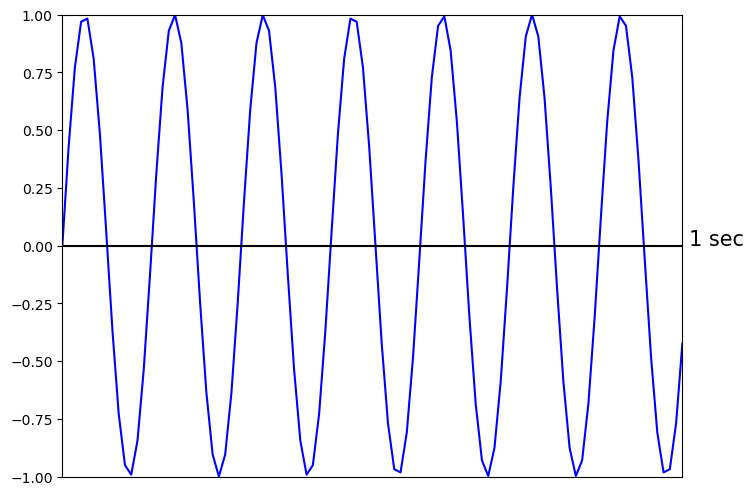

In [2]:
time = np.arange(0,1,0.01) #collecting 100 samples in a 1 second period
freq = 7
timeseries = np.sin(2*np.pi * freq * time) # sin(2𝜋 * 7 * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Although the plot shows a relatively smooth, continuous line from 0 to 2π, recall that the apparent
smoothness observed in the plot is created by joining equally spaced sample points (100 points in this
example). The 'make_plot' command interpolates the pixels that occur between the actual data points
to produce a nice looking image.

The values of the points plotted above can be obtained using the following Python code. First look at the individual y-axis datapoints and then find the length of the dataset.

In [3]:
timeseries = np.round(timeseries,3)
timeseries

array([ 0.   ,  0.426,  0.771,  0.969,  0.982,  0.809,  0.482,  0.063,
       -0.368, -0.729, -0.951, -0.992, -0.844, -0.536, -0.125,  0.309,
        0.685,  0.93 ,  0.998,  0.876,  0.588,  0.187, -0.249, -0.637,
       -0.905, -1.   , -0.905, -0.637, -0.249,  0.187,  0.588,  0.876,
        0.998,  0.93 ,  0.685,  0.309, -0.125, -0.536, -0.844, -0.992,
       -0.951, -0.729, -0.368,  0.063,  0.482,  0.809,  0.982,  0.969,
        0.771,  0.426,  0.   , -0.426, -0.771, -0.969, -0.982, -0.809,
       -0.482, -0.063,  0.368,  0.729,  0.951,  0.992,  0.844,  0.536,
        0.125, -0.309, -0.685, -0.93 , -0.998, -0.876, -0.588, -0.187,
        0.249,  0.637,  0.905,  1.   ,  0.905,  0.637,  0.249, -0.187,
       -0.588, -0.876, -0.998, -0.93 , -0.685, -0.309,  0.125,  0.536,
        0.844,  0.992,  0.951,  0.729,  0.368, -0.063, -0.482, -0.809,
       -0.982, -0.969, -0.771, -0.426])

In [4]:
len(timeseries)

100

Examine the y-axis values. Skipping the first point (time 0), notice that the second and last values are
the same, the third and second to last values are the same (except a different sign), and so on...

Use this Python command to add the values.

In [5]:
round(np.sum(timeseries),10)

-0.0

The sum is zero. Is this correct?

Answer:
    
Sure is. The 7 Hz timeseries is symmetric about 0.

Look at the plot again.

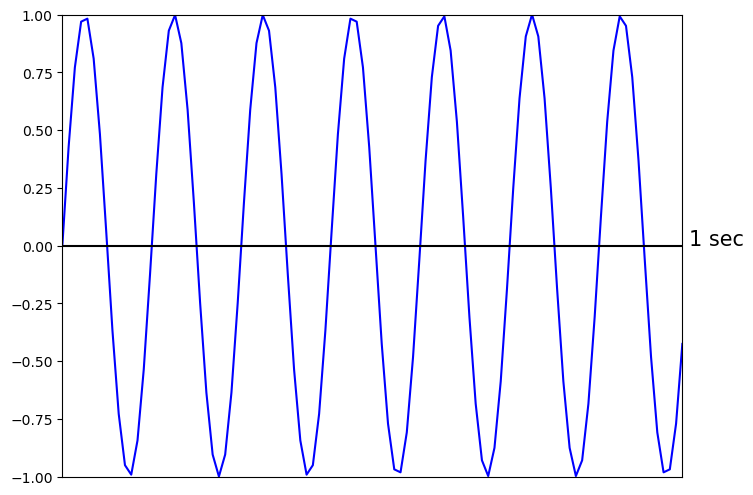

In [6]:
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The area (under the curve) above the x axis is equal to the area (above the curve) below the x axis. As a result, the total area from 0 to 1
second is zero.

Compute the mean of the 7 Hz sine wave.

In [7]:
round(np.mean(timeseries),10)

-0.0

The mean is 0. We knew this would be the case, since the sum was zero.

### <font color=red>DSP.03.B1.b) Computing the mean using a kernel</font>

In the example above, we computed the mean by summing each value and then dividing by the total
number of points. We can achieve the same result by multiplying each individual point by the reciprocal
of the length of the timeseries and then adding the values.

Give this a try. Create a vector of 100 values, with all values being the reciprocal of the length of the timeseries.

In [8]:
kernel = np.ones(100) * 0.01
kernel

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

Multiply this new kernel vector and the original timeseries. That is, compute the product of the first value in
each vector; compute the product of the second value in each; etc.

In [9]:
product1 = kernel * timeseries
product1

array([ 0.     ,  0.00426,  0.00771,  0.00969,  0.00982,  0.00809,
        0.00482,  0.00063, -0.00368, -0.00729, -0.00951, -0.00992,
       -0.00844, -0.00536, -0.00125,  0.00309,  0.00685,  0.0093 ,
        0.00998,  0.00876,  0.00588,  0.00187, -0.00249, -0.00637,
       -0.00905, -0.01   , -0.00905, -0.00637, -0.00249,  0.00187,
        0.00588,  0.00876,  0.00998,  0.0093 ,  0.00685,  0.00309,
       -0.00125, -0.00536, -0.00844, -0.00992, -0.00951, -0.00729,
       -0.00368,  0.00063,  0.00482,  0.00809,  0.00982,  0.00969,
        0.00771,  0.00426,  0.     , -0.00426, -0.00771, -0.00969,
       -0.00982, -0.00809, -0.00482, -0.00063,  0.00368,  0.00729,
        0.00951,  0.00992,  0.00844,  0.00536,  0.00125, -0.00309,
       -0.00685, -0.0093 , -0.00998, -0.00876, -0.00588, -0.00187,
        0.00249,  0.00637,  0.00905,  0.01   ,  0.00905,  0.00637,
        0.00249, -0.00187, -0.00588, -0.00876, -0.00998, -0.0093 ,
       -0.00685, -0.00309,  0.00125,  0.00536,  0.00844,  0.00

Examine the values. Skipping the first point (time 0), notice that the second and last values are the
same, the third and second to last values are the same (except a different sign), and so on... This is the same
pattern observed in the original timeseries. This had to be the case, because each value is simply scaled
to 1/100th of its original value.

Use this python command to compute the mean.

In [10]:
round(np.mean(product1),10)

0.0

The mean is zero. Is this correct?

Answer:
    
Sure is! Each value in the timeseries was multiplied by 1/100 and then we summed the values. This is, of
course, the same as summing the original values and then dividing by the total number of points.

In this example, each timeseries value was simply scaled to 1/100th of its original value. Because the
timeseries is symmetric about 0, the mean had to be 0, no matter how we scaled it.

### <font color=red>DSP.03.B1.c) Computing the mean using a kernel</font>

Instead of multiplying by a constant, let's try adding a constant. Check out this modification - a constant
of 5 is added to each value in the 7 Hz timeseries.

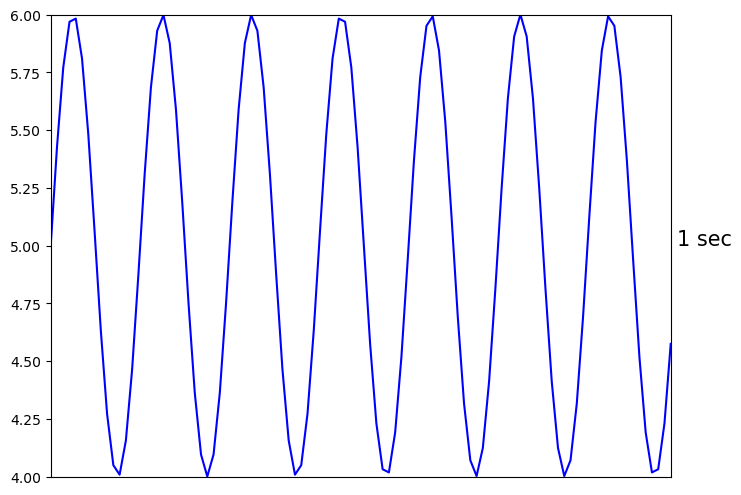

In [11]:
time = np.arange(0,1,0.01) # collecting 100 samples in a 1 second period
freq = 7
timeseries = np.sin(2*np.pi * freq * time) + 5 # sin(2𝜋 * 7 * time) + 5

make_plot_1(time,timeseries)
plt.ylim((4,6))
plt.text(1,5,'1 sec',fontsize=15)
plt.show()

Find the length of the dataset and look at the y-axis values.

In [12]:
len(timeseries)

100

There are 100 values (only the amplitude values (y axis) are shown). Notice that the values are symmetric
about 5.

Create a vector of 100 values with all 100 values the reciprocal of the length of the timeseries (this time
don't display the 100 values).

In [13]:
kernel = np.ones(100) * 0.01

Last time, corresponding datapoints in each vector were multiplied and the products summed. This
calculated the mean of the original timeseries. Perform these two mathematical operations using a
single command.

In [14]:
round(np.inner(timeseries, kernel))

5

This strongly suggests that the mean value is 5. Is this correct?

Answer:
    
Sure is. A constant value (5) was added to the original timeseries. As a result, the 7 Hz sine wave is now
symmetric about 5, not about zero.

Look at the plot.

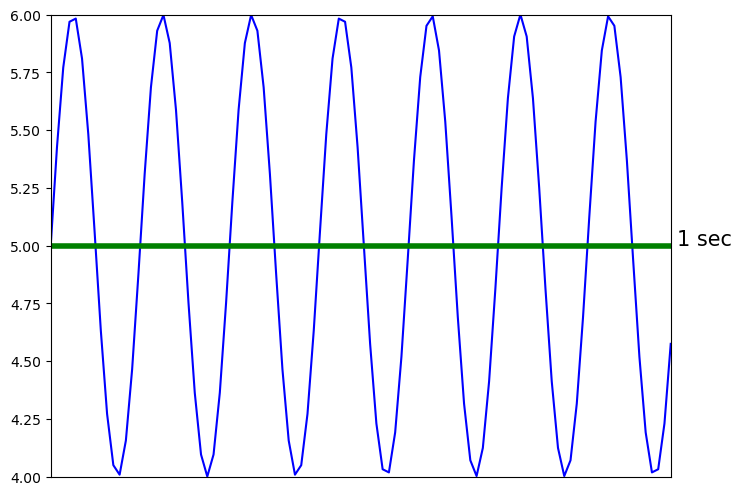

In [15]:
make_plot_1(time,timeseries)
plt.ylim((4,6))
plt.text(1,5,'1 sec',fontsize=15)
plt.axhline(y=5, color='g', linewidth = 4)

plt.show()

The green horizontal line intersects the y axis at 5. This 7 Hz activity oscillates symmetrically above and
below 5. As a result, the mean value is 5.

Calculate the mean the more straightforward way.

In [16]:
round(np.mean(timeseries),10)

5.0

### <font color=red>DSP.03.B1.d) Computing the mean using a kernel and finding the DC offset</font>

Check out another example. Add a constant of 33.

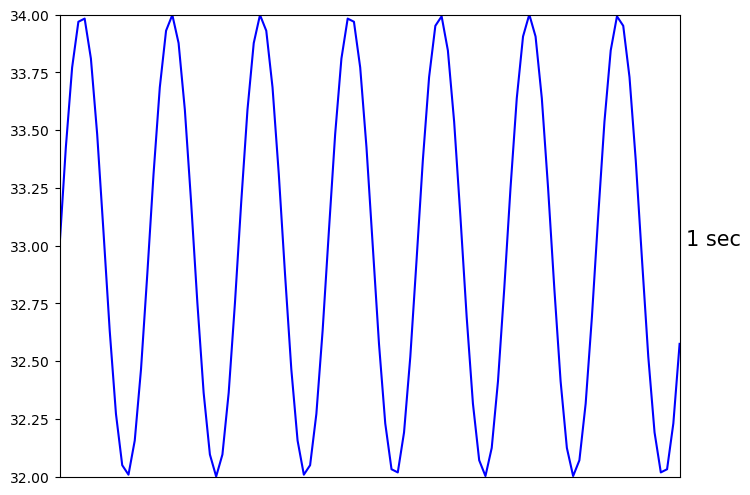

In [17]:
time = np.arange(0,1,0.01)  # collecting 100 samples in a 1 second period
freq = 7
timeseries = np.sin(2*np.pi * freq * time) + 33 # sin(2𝜋 * 7 * time) + 33

make_plot_1(time,timeseries)
plt.ylim((32,34))
plt.text(1,33,'1 sec',fontsize=15)
plt.show()

Find the length of the dataset and look at the y-axis amplitude values.

In [18]:
len(timeseries)

100

In [19]:
timeseries

array([33.        , 33.42577929, 33.77051324, 33.96858316, 33.98228725,
       33.80901699, 33.48175367, 33.06279052, 32.63187545, 32.27103137,
       32.04894348, 32.0078853 , 32.15567207, 32.46417321, 32.87466677,
       33.30901699, 33.68454711, 33.92977649, 33.99802673, 33.87630668,
       33.58778525, 33.18738131, 32.75131011, 32.36257601, 32.09517295,
       32.        , 32.09517295, 32.36257601, 32.75131011, 33.18738131,
       33.58778525, 33.87630668, 33.99802673, 33.92977649, 33.68454711,
       33.30901699, 32.87466677, 32.46417321, 32.15567207, 32.0078853 ,
       32.04894348, 32.27103137, 32.63187545, 33.06279052, 33.48175367,
       33.80901699, 33.98228725, 33.96858316, 33.77051324, 33.42577929,
       33.        , 32.57422071, 32.22948676, 32.03141684, 32.01771275,
       32.19098301, 32.51824633, 32.93720948, 33.36812455, 33.72896863,
       33.95105652, 33.9921147 , 33.84432793, 33.53582679, 33.12533323,
       32.69098301, 32.31545289, 32.07022351, 32.00197327, 32.12

There are 100 values.

Create a vector of 100 values with all 100 values being the reciprocal of the length of the timeseries.

In [20]:
kernel = np.ones(100) * 0.01

Multiply corresponding values in the data and the kernel and then compute the sum.

In [21]:
round(np.inner(timeseries, kernel))

33

This indicates that the mean value is 33. Is that correct?

Answer:
    
Sure is! A constant value was added to the original timeseries. As a result, the 7 Hz sine wave is symmetric
about the constant value of 33.

Look at the plot again.

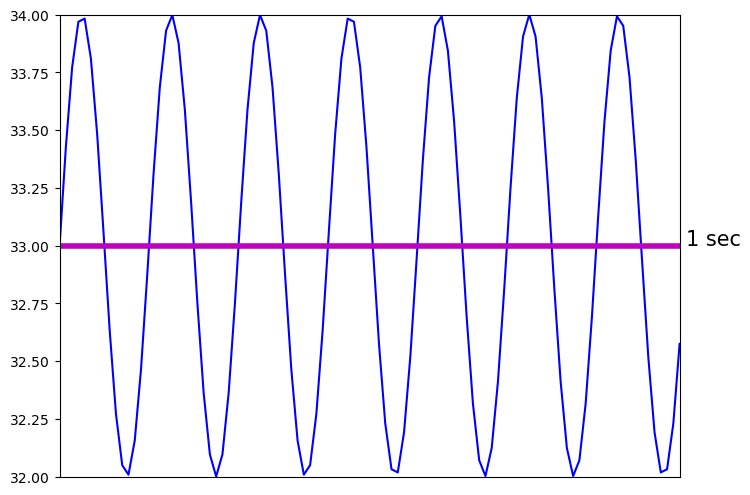

In [22]:
make_plot_1(time,timeseries)
plt.ylim((32,34))
plt.text(1,33,'1 sec',fontsize=15)
plt.axhline(y=33, color='m', linewidth = 4)
plt.show()

The magenta line intersects the y axis at 33. So this 7 Hz activity oscillates symmetrically above and
below 33.

Calculate the mean.

In [23]:
round(np.mean(timeseries),10)

33.0

Yup - checks out. The mean value is 33.

This mean value is often referred to as the DC value. In the above examples, the DC is a constant, and
the DC offset is an offsetting of a signal from zero.

If the mean amplitude is zero, we say that there is no DC offset.
If the mean amplitude is non-zero, we say that there is a DC offset.

The term "DC" comes from "Direct Current" in electricity and refers to a constant current through a constant resistance at a constant voltage (not a voltage
that fluctuates sinusoidally - that is AC = alternating current). The batteries in a flashlight provide a constant voltage (until they wear out) across a constant resistance (the lightbulb) to provide a constant current through the lightbulb.

We added a constant value of 5 or 33. This is sometimes called an "offset" or a "DC offset". The DC
offset can be removed by subtracting the mean amplitude from each sample point (as long as the DC
offset is constant across time, which it should be, to be truly DC).

Check it out.

In [24]:
round(np.mean(timeseries - 33),10)

0.0

Zero. The DC offset was successfully removed. Subtracting the mean value of a timeseries (i.e., subtracting the DC offset) leaves the AC (fluctuating) portion of the signal, if any. So, subtracting the mean is a way to separate the DC and AC portions of a signal.

## <font color=red>DSP.03.B2) Moving averages</font>

### <font color=red>DSP.03.B2.a) Creating a kernel</font>

We saw above that one way to compute the mean is to multiply all datapoints in the timeseries by
the reciprocal of the length of the timeseries and then sum the products. In this section, we will examine
a standard signal processing technique that requires only a slight modification of that procedure.

Look at this timeseries, which contains a 2 Hz signal and a 60 Hz signal, digitized at 300 Hz.

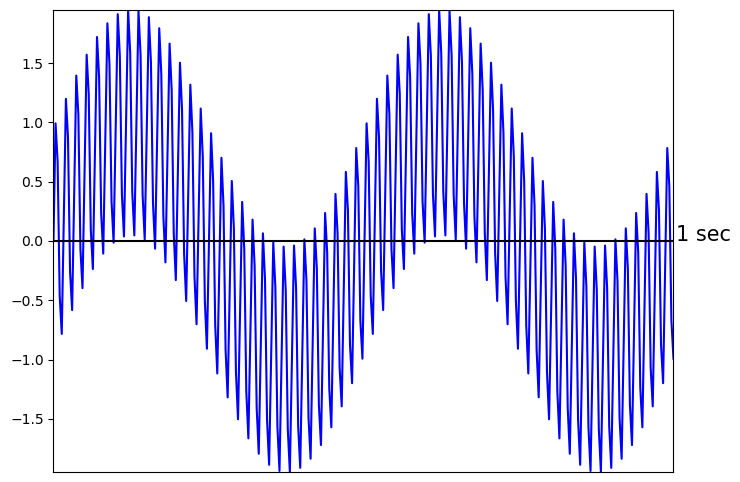

In [25]:
time = np.arange(0,1,1/300)
timeseries = np.sin(2*np.pi * 2 * time) + np.sin(2*np.pi * 60 * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

What if, instead of multiplying and summing all datapoints to compute the average from 0 to 1 second,
an average value was obtained for shorter sections of the timeseries?

How about calculating the mean for just a few contiguous points?

Imagine placing a box of size 10 over the first 10 values.

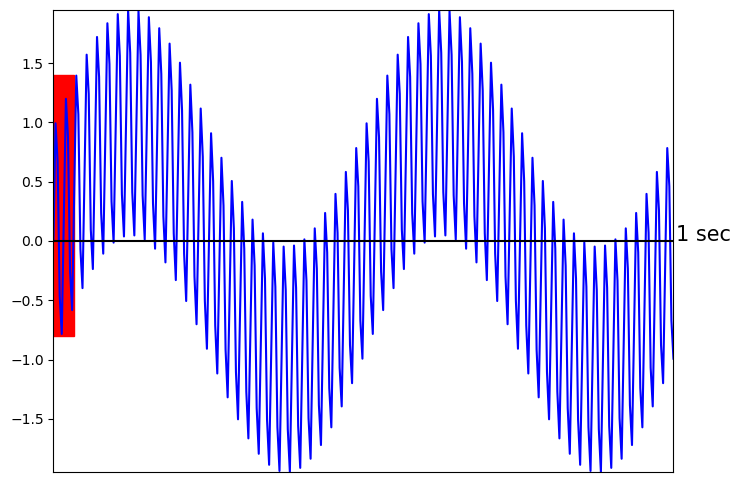

In [26]:
fig = plt.figure()
ax = fig.add_subplot()

# Create a Rectangle patch
rect = patches.Rectangle((0, -.8), 0.03322, 2.2, linewidth=1, edgecolor='r', facecolor='r')

# Add the patch to the Axes
ax.add_patch(rect)

# Plotting time vs amplitude 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The mean value of the datapoints enclosed by the red box is calculated by starting with a vector of
10 values { 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 } . Call this vector a "kernel".
If we multiply each value in the kernel by the first 10 points in the timeseries, and if we then sum these
values, this computes the mean of those first 10 points.

We can use a mathematical procedure to quickly accomplish this - simply compute what is called the
'dot product' of (a) the kernel and (b) the first 10 timeseries datapoints. The dot product multiplies corresponding
points in the two vectors and then sums the products.

This is accomplished using the Python command 'Dot'.

In [27]:
firstpoint = timeseries[:10]
kernel = 0.1 * np.ones(10)
round(np.dot(firstpoint,kernel),6)

0.186028

A new value of 0.186028 is obtained. This is the mean value of the first 10 points.

We just tried that using the first 10 points. But we could do the same trick elsewhere in the data. Let's
move the box (i.e., the kernel) one point to the right. (The move won't be visually obvious unless there's high screen resolution.)

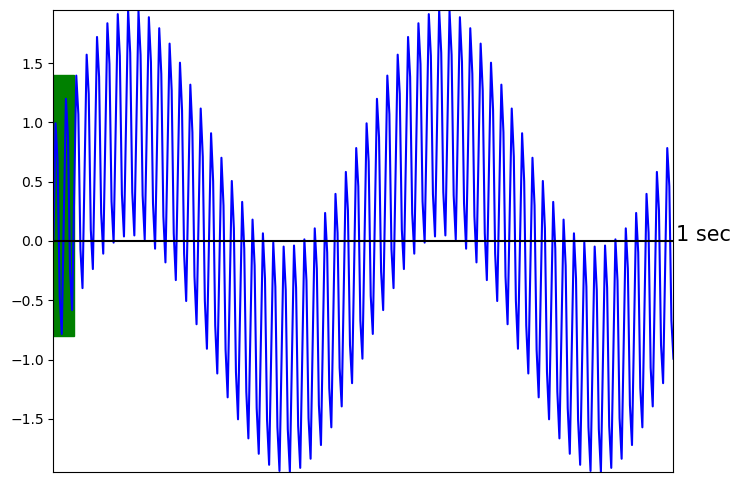

In [28]:
fig = plt.figure()
ax = fig.add_subplot()

# Create a Rectangle patch
rect = patches.Rectangle((0, -0.8),0.03322, 2.2, linewidth=1, edgecolor='g', facecolor='g')

# Add the patch to the Axes
ax.add_patch(rect)

# Plotting time vs amplitude 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The mean value of the datapoints enclosed by the second box is calculated by multiplying the vector of
10 values  { 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 , 1/10 } with the second set of 10 datapoints in the original
timeseries and then summing those values.

To calculate the mean, simply take the dot product of the kernel (i.e, the vector of ten 0.01 values) and the
2nd to 11th datapoints in the original timeseries.

In [29]:
secondpoint = timeseries[1:11]
kernel = 0.1 * np.ones(10)
round(np.dot(secondpoint,kernel),6)

0.226702

This provides a mean of 0.226702. Note that we did not change the kernel. We just applied it to a
slightly different set of data points. Note also that the resulting value is a little bigger than the 0.186028 we got the first time, again because we applied it to a slightly different set of data points.

Get a third result - the dot product of the kernel (i.e, the vector of 10 values) and the third 10 data points
in the original timeseries.

In [30]:
thirdpoint = timeseries[2:12]
kernel = 0.1 * np.ones(10)
round(np.dot(thirdpoint,kernel),6)

0.266978

This provides a mean of 0.266978.

We could continue this way, gradually moving through the timeseries, until we calculate a final point - the dot product of the kernel (i.e, the same
vector of 10 values) and the last 10 datapoints in the original timeseries. 

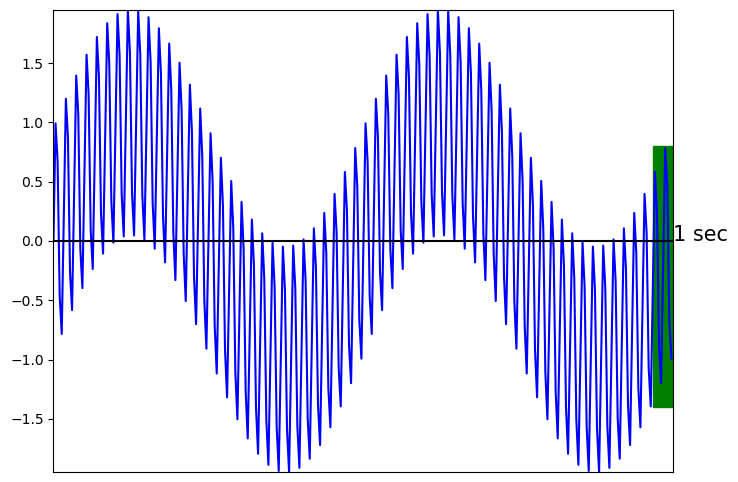

In [31]:
fig = plt.figure()
ax = fig.add_subplot()

# Create a Rectangle patch
rect = patches.Rectangle((0.966774, -1.4), 0.03322, 2.2, linewidth=1, edgecolor='g', facecolor='g')

# Add the patch to the Axes
ax.add_patch(rect)

# Plotting time vs amplitude 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Calculate the final point.

In [32]:
thirdpoint = timeseries[290:300]
kernel = 0.1 * np.ones(10)
round(np.dot(thirdpoint,kernel),6)

-0.226702

This provides a final mean of -0.226702.

Let's take a break for a moment and take stock of something: we have several different numbers
characterizing our example.

a) We have one second of a 2 Hz sine wave.

b) We have one second of a 60 Hz sine wave.

c) We're sampling the time series that is the sum of those two at 300 Hz, so we have 300 data points.

d) We're grabbing a subset of those 300 samples - just 10 at a time.

e) We're choosing where in the 300 data points we start grabbing the 10 points.

f) We compute the dot product, producing a single number that represents the average of those 10
points.

Think about it: we could change any of these numbers, and we'd have a different example. But the
approach would be the same - we'd end up with an average of a subset of our data. OK, back to work.

Use the code below to move the kernel across the timeseries, one datapoint at a time, calculating the
mean at each location. We'll end up with almost as many average values as we have raw data points.
(Things get a little problematic at each end of the timeseries, but don't bother about that for now, either in your thinking or in the next plot.) In fact, we can assemble all
those averages into a new vector.

 The set of new values (think of it as a new timeseries) is plotted below.

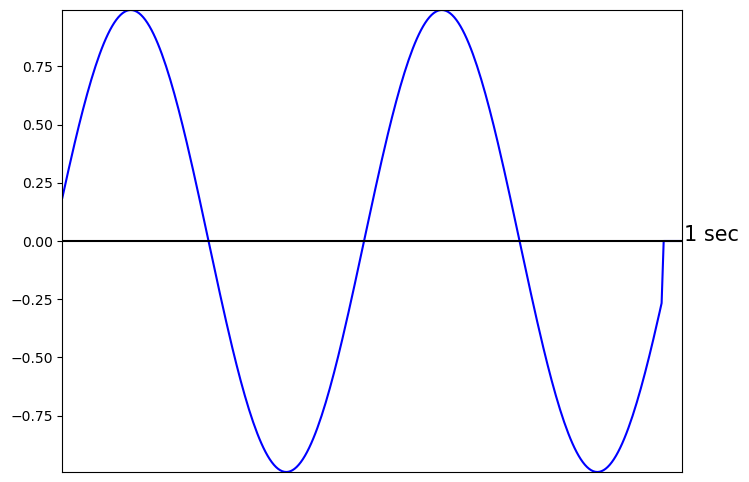

In [33]:
kernel = 0.1 * np.ones(10)
newydata = np.zeros(300)
for point in range(0,290):
    newydata[point] = np.dot(kernel,timeseries[point:point + 10])
newydata[290:300] = 0

# Plotting time vs amplitude 
make_plot_1(time,newydata)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

This is the new timeseries created by calculating the dot product of the kernel and successive sets of 10
datapoints in the original timeseries.

Is there a difference between the original timeseries and the new timeseries?

Answer: Take a look.

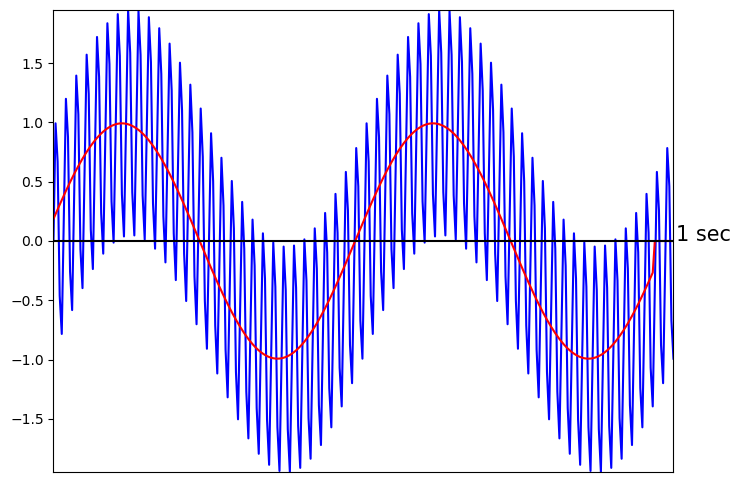

In [34]:
make_plot_2(time,timeseries,'blue', time, newydata,'red')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The new timeseries is shown in red. It looks like 60 Hz activity has been removed.

Compare the powerspectrum of the two timeseries.

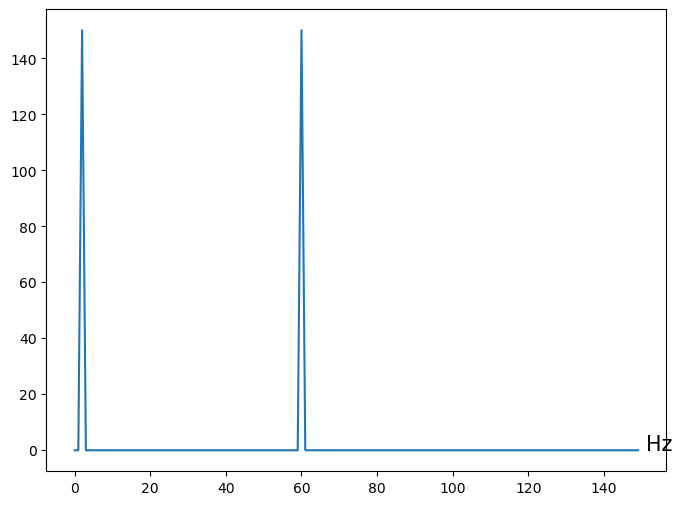

In [35]:
make_plot_freq_1(timeseries,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

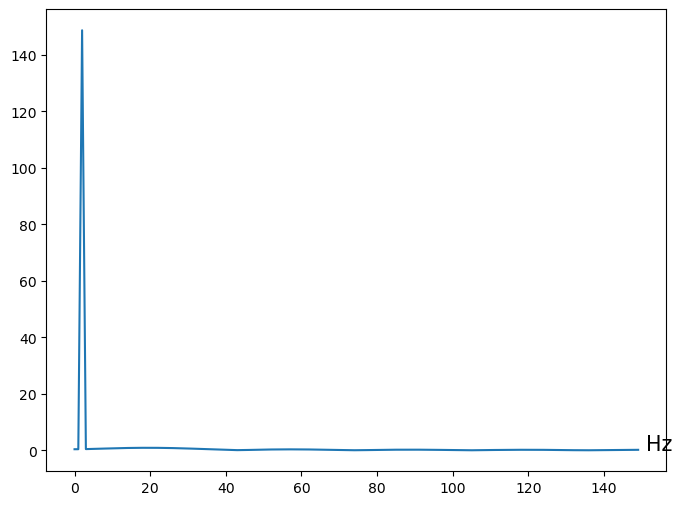

In [36]:
make_plot_freq_1(newydata,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

In the second power spectrum, 2 Hz activity is retained, and 60 Hz activity is completely attenuated.
What is going on? 

Answer:
    
We can think of what we did as one way to apply a digital filter.

The term "digital" filter is used for a wide range of techniques that may only have in common the fact
that they are mathematical procedures that are applied to discrete numeric representations of discrete
or continuous waveforms in order to selectively augment or more commonly to attenuate certain
frequencies. (If the original signal was discrete, we can work with the original series of values. If the original signal was continuous, we had to digitize it before we could do our arithmetic.)

For our purposes, a filter is an entity that augments or attenuates certain frequencies. A digital filter accomplishes that via
arithmetic. The alternative is an analog filter, which accomplishes it with circuitry.

### <font color=red>DSP.03.B2.b) Creating a different kernel</font>

Look at another example.

Stay with the timeseries above. However, in this case we're going to multiply each point in the original
timeseries by a vector of 3 values, instead of a vector of 10 values.

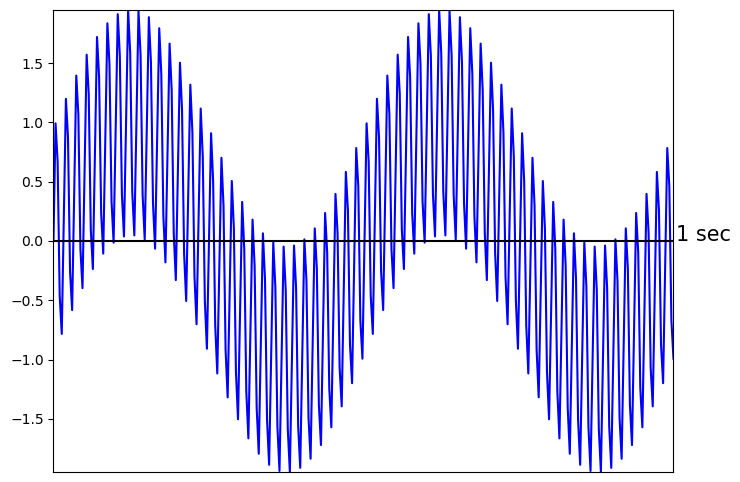

In [37]:
time = np.arange(0,1,1/300)
timeseries = np.sin(2*np.pi * 2 * time) + np.sin(2*np.pi * 60 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Use the code below to move a kernel of size 3 across the timeseries, one datapoint at a time, calculating
the mean at each location. The set of new values (think of it as a new timeseries) is plotted below. (Again, don't bother about happens at the very beginning and end of the new timeseries.)

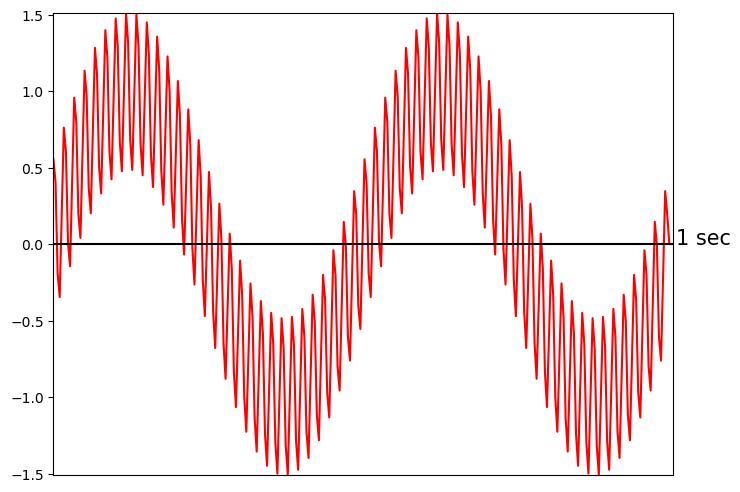

In [38]:
kernel = 1/3 * np.ones(3)
newydata = np.zeros(300)
for point in range(0,297):
    newydata[point] = np.dot(kernel,timeseries[point:point + 3])
newydata[297:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Is there a difference between the original timeseries and the timeseries created by multiplying the
original timeseries by the kernel of size 3?

Answer: Take a look.

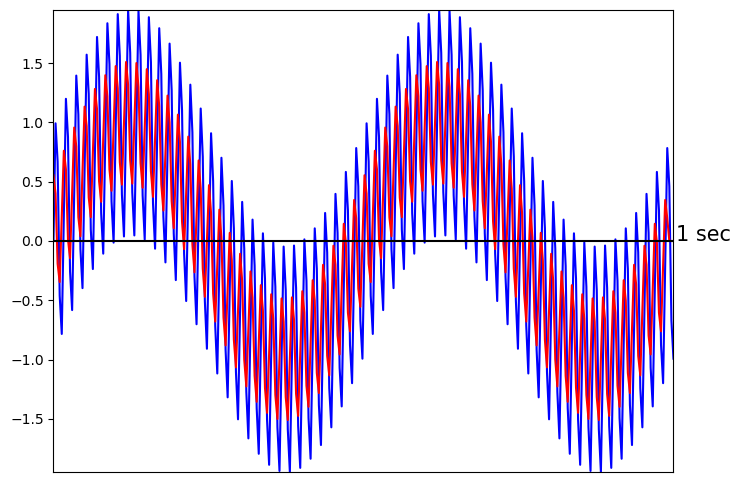

In [39]:
make_plot_2(time,timeseries,'blue', time, newydata,'red')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The new timeseries is shown in blue. 60 Hz activity is attenuated, but this time it is not completely
removed.

Compare the powerspectrum of the two timeseries.

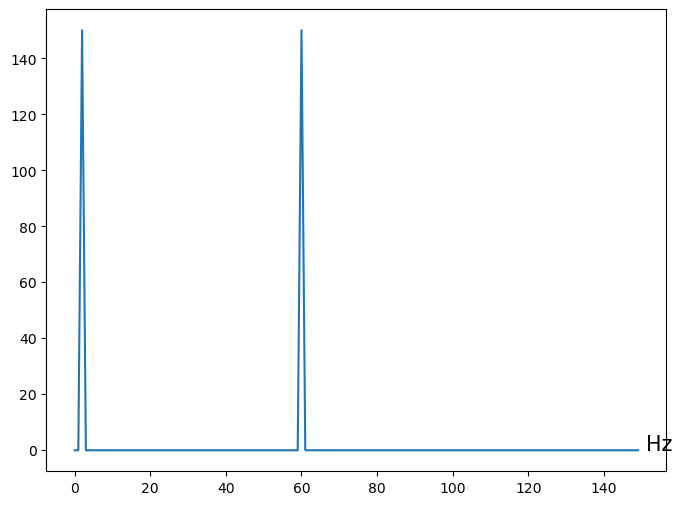

In [40]:
make_plot_freq_1(timeseries,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

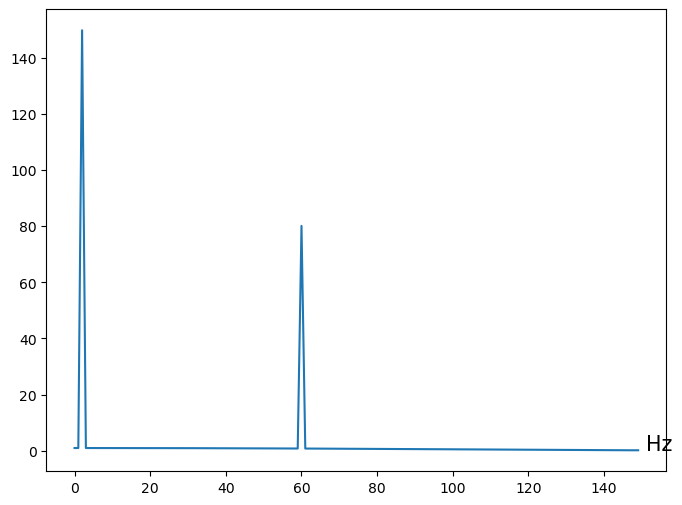

In [41]:
make_plot_freq_1(newydata,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

60 Hz activity is attenuated but not completely removed.

What is going on?

Answer: This requires an extended explanation. No room to do that here. More later. For now, please continue to Section B.3.

## <font color=red>DSP.03.B3) Convolving and Filtering</font>

### <font color=red>DSP.03.B3.a) Removing activity at a specific frequency</font>

Continuing from Section B.2.b, it's possible you might be asking yourself, 'What happened to the 60 Hz
activity?'. In the first example, 60 Hz activity was completely removed. In the second example, 60 Hz
activity was attenuated (attenuated means decreased) but not completely removed.

Plot the function from B.2.b and then overlay a 2 Hz timeseries.

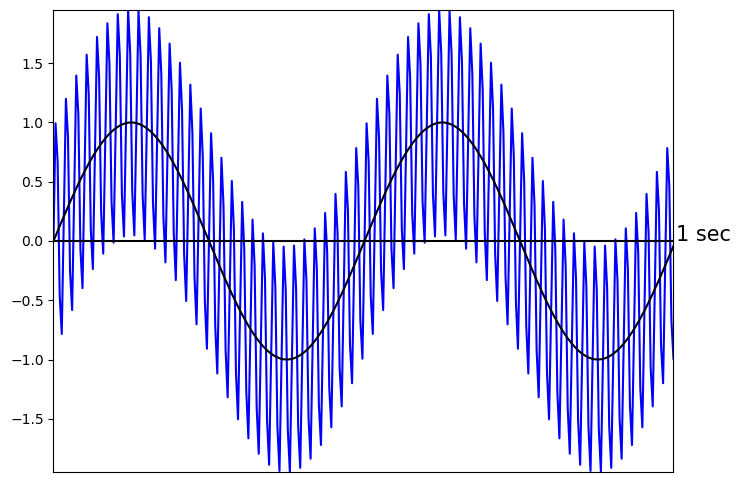

In [42]:
time = np.arange(0,1,1/300)
timeseries1 = np.sin(2*np.pi * 2 * time) + np.sin(2*np.pi * 60 * time)
timeseries2 = np.sin(2*np.pi * 2 * time)

make_plot_2(time,timeseries1,'b', time, timeseries2,'k')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The combined 60 Hz and 2 Hz timeseries (shown in blue) appears to be symmetric about the 2 Hz sine
wave (shown in black).

Use the dot product command to calculate the mean of the first 5 points in the original data (blue), and
then plot this new point at the x-axis location of the 3rd point, which is at the position of the middle of
the first 5 points.

In [43]:
firstpoint = timeseries1[:5]
kernel = 1/5 * np.ones(5) #this looks like { 1/5 , 1/5 , 1/5 , 1/5 , 1/5 }
round(np.dot(firstpoint,kernel),6)

0.083531

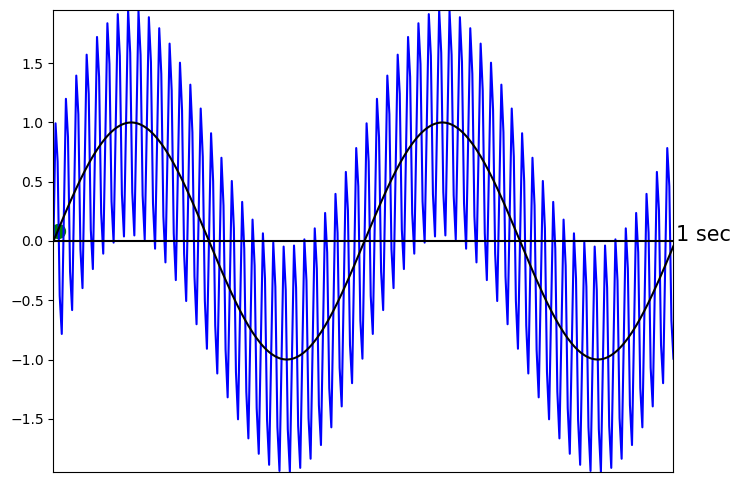

In [44]:
make_plot_2(time,timeseries1,'b', time, timeseries2,'k')
plt.scatter(time[2],0.083531,c ="green",s=100)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The mean value of the first 5 points falls on the 2 Hz waveform.

Calculate the mean of the second group of 5 points and place this new value on the plot.

In [45]:
secondpoint = timeseries1[1:6]
kernel = 1/5 * np.ones(5) #this looks like { 1/5 , 1/5 , 1/5 , 1/5 , 1/5}
round(np.dot(secondpoint,kernel),6)

0.125113

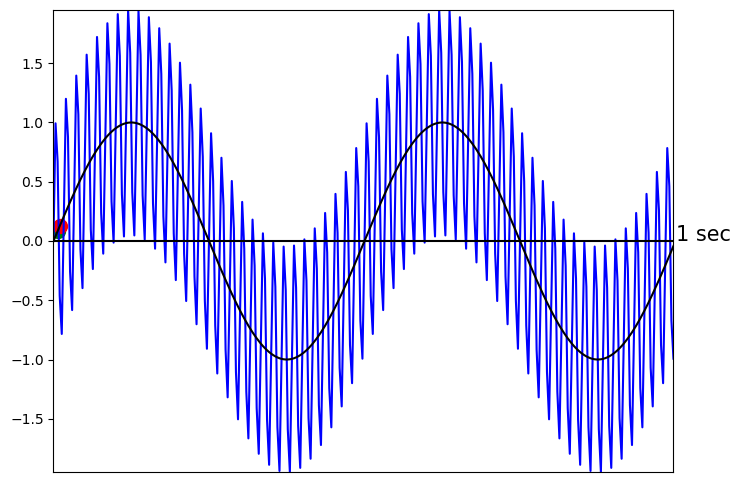

In [46]:
make_plot_2(time,timeseries1,'b', time, timeseries2,'k')
plt.scatter(time[2],0.083531,c ="green",s=100)
plt.scatter(time[3],0.125113,c ="red",s=100)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The mean value of the second 5 points falls on the 2 Hz waveform, displaced slightly up from and to the right of the first mean we plotted.

Calculate the mean for a group of 5 points somewhere in the middle of the timeseries and place this
new value on the plot.

In [47]:
midpoint = timeseries1[119:124]
kernel = 1/5 * np.ones(5)
round(np.dot(midpoint,kernel),6)

-0.935638

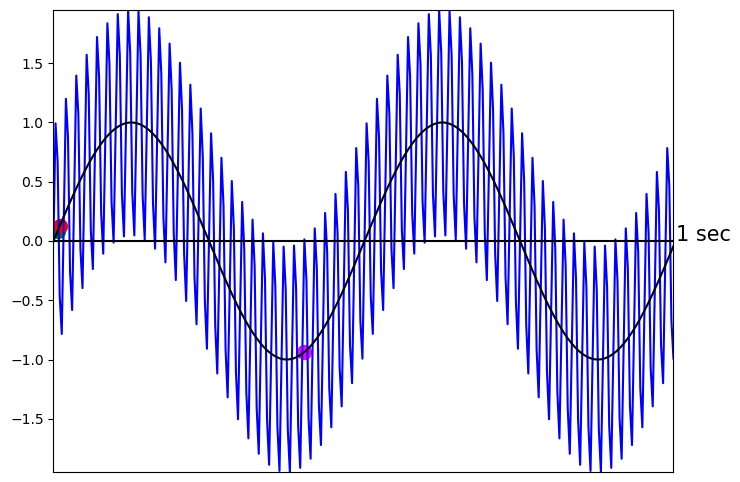

In [48]:
make_plot_2(time,timeseries1,'b', time, timeseries2,'k')
plt.scatter(time[2],0.083531,c ="green",s=100)
plt.scatter(time[3],0.125113,c ="red",s=100)
plt.scatter(time[121],-0.935638,c ="magenta",s=100)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

This point falls on the 2 Hz waveform.

This is evidence that, when five points are averaged, the value will always fall on the 2 Hz waveform.

Try it for a random point.

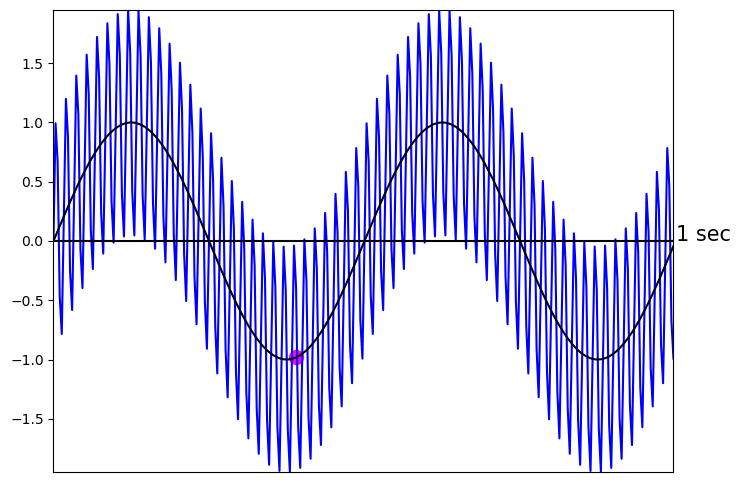

In [49]:
randomnum = np.random.randint(2,297,size=1)
randomnum = randomnum[0]
randompoint = timeseries1[randomnum-2:randomnum+3]
kernel = 1/5 * np.ones(5)
ycoordinate = round(np.dot(randompoint,kernel),6)

make_plot_2(time,timeseries1,'b', time, timeseries2,'k')
plt.scatter(time[randomnum],ycoordinate,c ="magenta",s=100)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Run the above cell several times to see that the dot always falls right on the 2 Hz line.

Here is a question - will a kernel of any size place the dot on the 2 Hz line (and therefore always remove
60 Hz activity)?

Answer:
    
If the kernel covers a full cycle of 60 Hz activity (and as long as there is nothing other than the 2 Hz and 60 Hz we're playing with), then we are guaranteed
that the mean value will always fall on the 2 Hz line and thus remove all 60 Hz activity.

How come that works?

The 60 Hz sine wave above completes 60 full cycles in 300 points.

As 300/60 = 5, a kernel of size 5 covers one complete period of a 60 Hz sine wave. So, the average of any 5 consecutive points will always average out the 60 Hz portion of the combined signal, because (as we found earlier) a single sine-wave cycle has a mean of zero.

Because the 60 Hz activity 'rides' on the 2 Hz sine wave, oscillating symmetrically above and below the
2 Hz line, the mean of 60 Hz activity for a complete period always falls on the 2 Hz line.

So, our 5-point kernel successfully filters out 60 Hz activity. For that to work, the length of our kernel depends on our sample rate. We'll expore that next.

### <font color=red>DSP.03.B3.b) Removing activity at a specific frequency - more details</font>

Continuing with the previous example, instead of a kernel of length 5, what happens when a kernel of length 3 is applied (i.e., covering
slightly less than a one full cycle of 60 Hz activity)?

Create the time series.

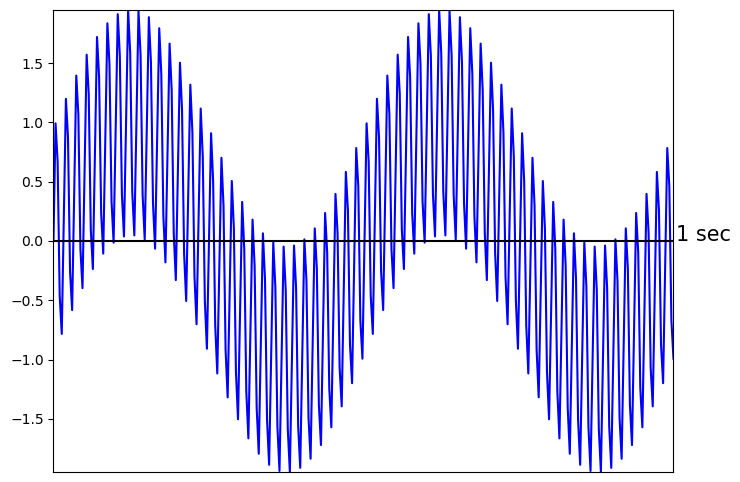

In [50]:
time = np.arange(0,1,1/300)
timeseries = np.sin(2*np.pi * 2 * time) + np.sin(2*np.pi * 60 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Apply a kernel of length 3.

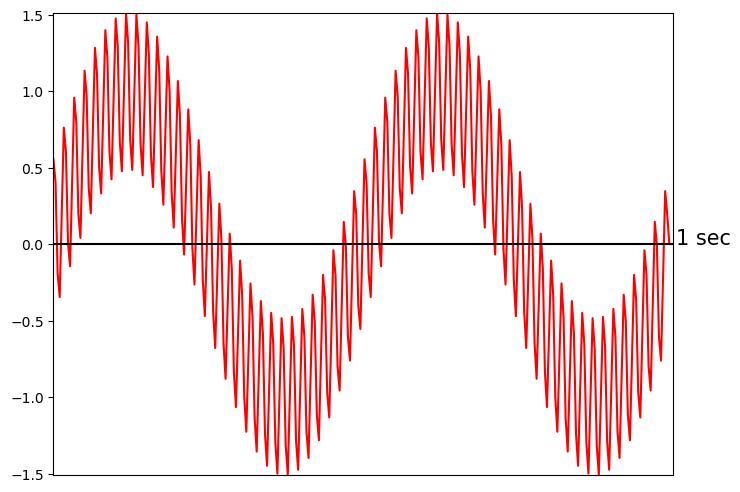

In [51]:
kernel = 1/3 * np.ones(3)
newydata = np.zeros(300)
for point in range(0,297):
    newydata[point] = np.dot(kernel,timeseries[point:point + 3])
newydata[297:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Is there a difference between the original timeseries and the new timeseries?

Answer: Take a look.

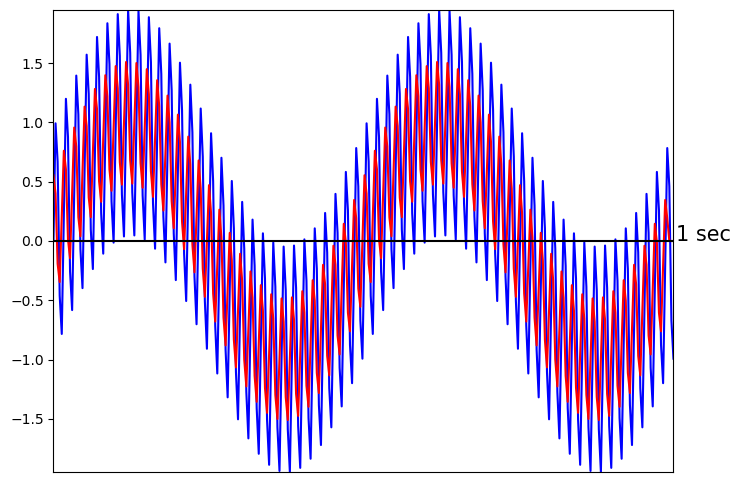

In [52]:
make_plot_2(time,timeseries,'b', time, newydata,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

60 Hz activity is attenuated, but not completely removed.

Compare the power spectrum of the old and new timeseries.

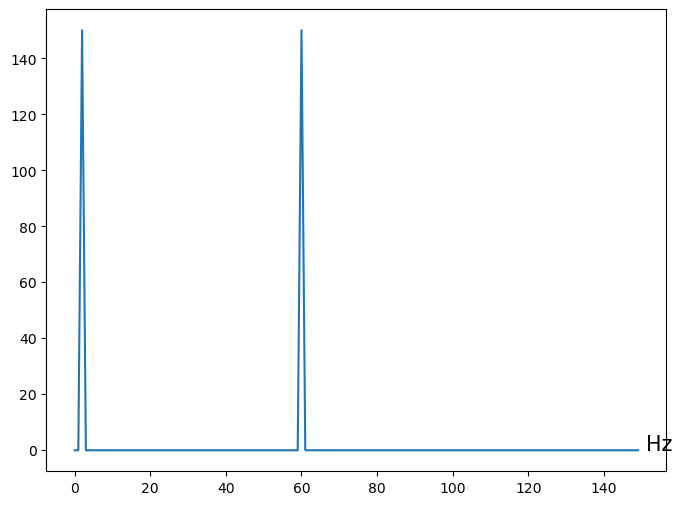

In [53]:
make_plot_freq_1(timeseries,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

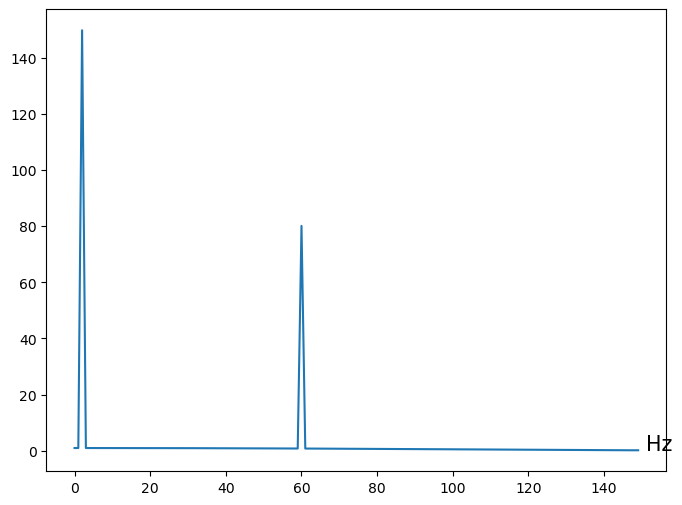

In [54]:
make_plot_freq_1(newydata,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

The power spectra look different. 60 Hz activity has been reduced but not completely removed.

There are 300 points in the unfiltered timeseries. The 60 Hz sine wave completes 60 full cycles in 300
points. As 300/60 = 5, a kernel of 5 points is needed to cover a full cycle of 60 Hz activity.

A kernel of 3 points does not cover one complete 60 Hz cycle. As a result, when using a kernel of size 3,
not all 60 Hz activity is removed. Think about it: the mean of 3 points, not covering a full cycle, won't be zero. What it'll be depends on where in the cycle the 3 points land.

Just to check, see if a kernel of size 4 works. Create the unfiltered time series.

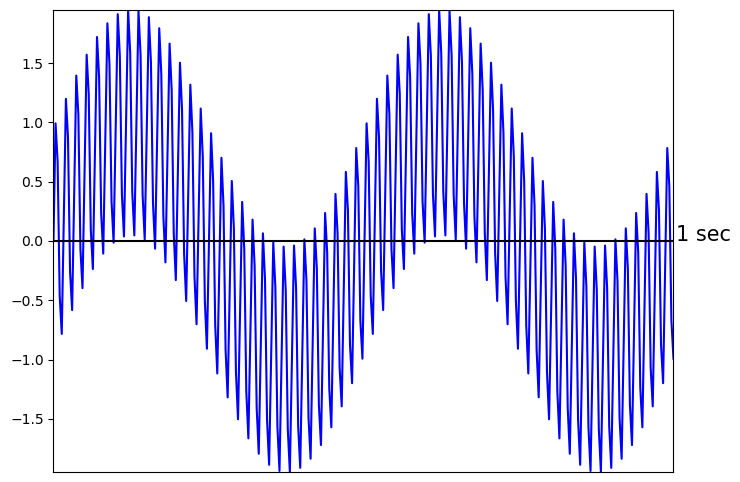

In [55]:
time = np.arange(0,1,1/300)
freq1 = 2
freq2 = 60
timeseries = np.sin(2*np.pi * freq1 * time) + np.sin(2*np.pi * freq2 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Apply a kernel of length 4.

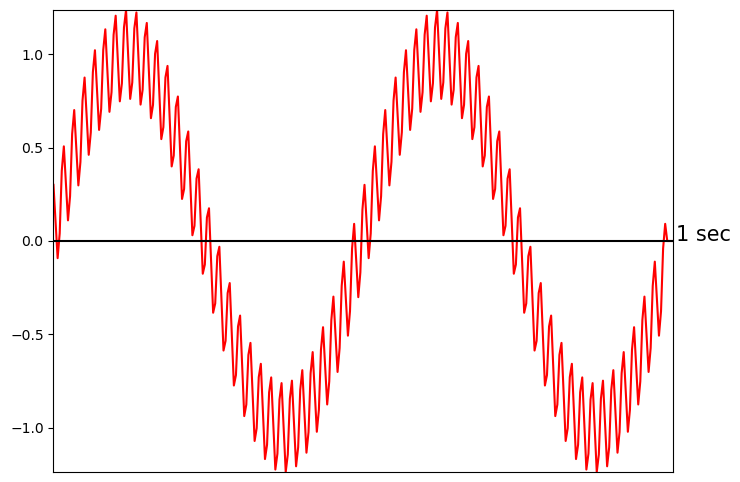

In [56]:
kernel = 1/4 * np.ones(4) #this looks like {1/4 , 1/4 , 1/4 , 1/4 }
newydata = np.zeros(300)
for point in range(0,296):
    newydata[point] = np.dot(kernel,timeseries[point:point + 4])
newydata[296:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

60 Hz activity is reduced but still present.

Again, that is because a kernel of size 4 does not completely span one full period of 60 Hz activity.
Remember when we took a break in section B.2.a and listed the various numbers that defined the
example we were using? We said that we could change any of those. It turns out that the values we
select for those numbers have an impact on how our filter behaves.

### <font color=red>DSP.03.B3.c) Filtering outcomes depend on the relationship between the kernel size and the sampling rate</font>

Look at this timeseries, which has 5 Hz asnd 80 Hz components.

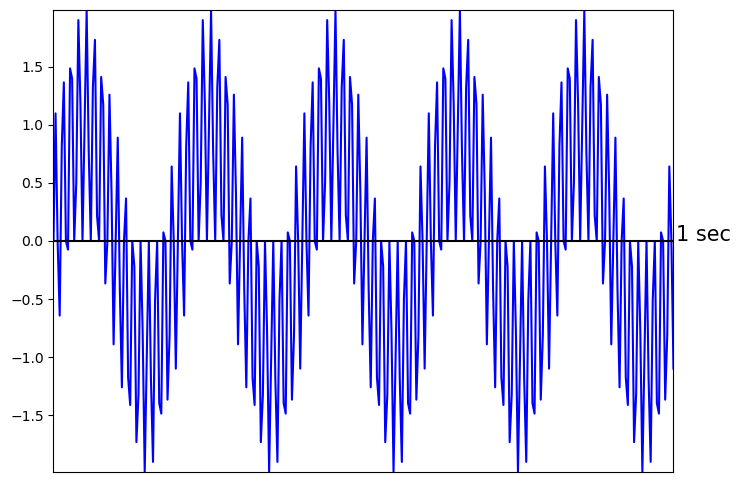

In [57]:
time = np.arange(0,1,1/300)
timeseries = np.sin(2*np.pi * 5 * time) + np.sin(2*np.pi * 80 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Create a kernel that contains 6 values and calculate the dot product between the kernel and each
datapoint in the original unfiltered timeseries.

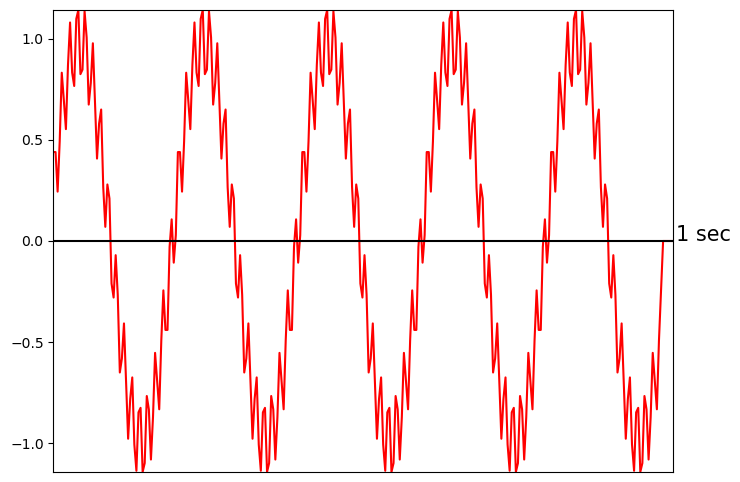

In [58]:
kernel = 1/6 * np.ones(6) #this looks like {1/6 , 1/6 , 1/6 , 1/6 , 1/6, 1/6}
newydata = np.zeros(300)
for point in range(0,294):
    newydata[point] = np.dot(kernel,timeseries[point:point + 6])
newydata[294:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Is there a difference between the unfiltered timeseries (i.e., original timeseries) and the filtered timeseries
(created by calculating the dot product between the kernel and each datapoint in the original
timeseries)?

Answer: Take a look.

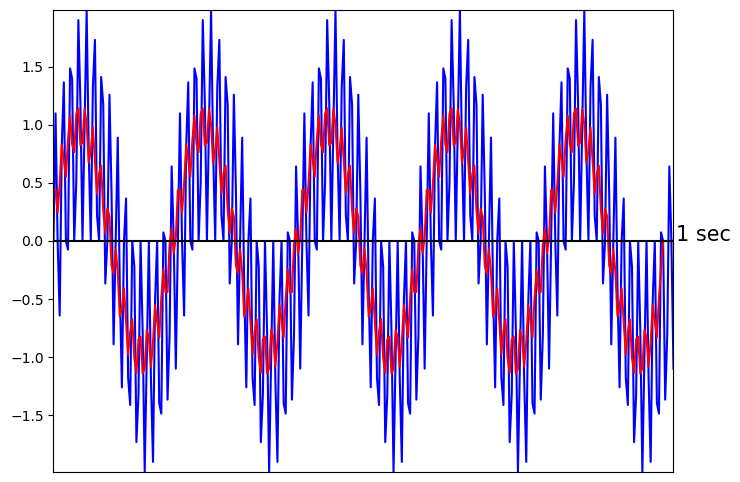

In [59]:
make_plot_2(time,timeseries,'b', time, newydata,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

They look different. Most, but not all, of the 80 Hz activity has been removed.

Compare the power spectrum of the old and new timeseries.

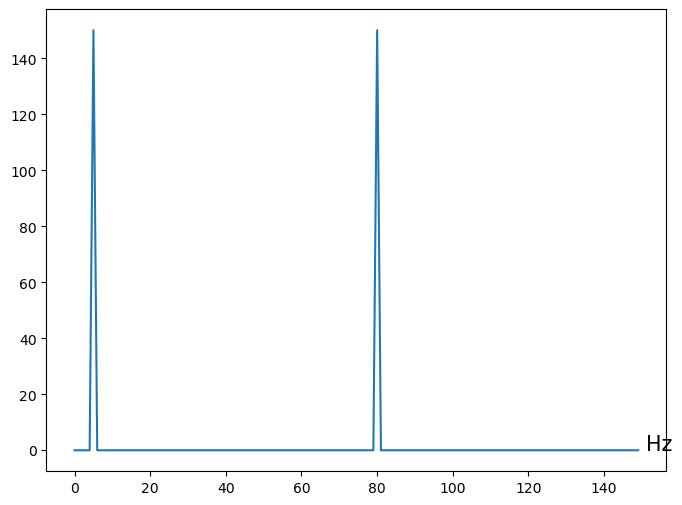

In [60]:
make_plot_freq_1(timeseries,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

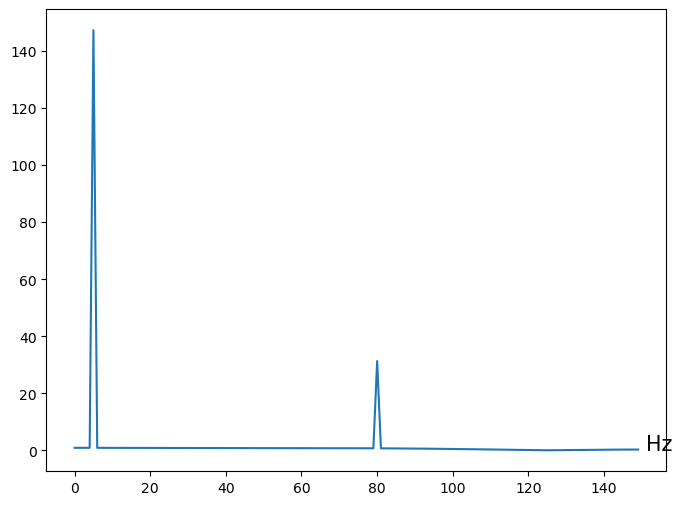

In [61]:
make_plot_freq_1(newydata,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

80 Hz activity is still present.

The 80 Hz sine wave completes 80 full cycles over a 1 second = 300 point interval.
As 300/80 = 3.75, a kernel of at least 4 points is needed to cover one full cycle of 80 Hz activity.
Above, a kernel of 6 points was used. Isn't a kernel of size 6 sufficient to cover one full cycle of 80 Hz
activity? What's going on?

Answer:
    
When sampling at 300 Hz, one complete period of 80 Hz activity does not end at an integer value. A
kernel of size 6 does not span an integer number of cycles. In other words, our kernel is not grabbing
exactly 1 cycle, or exactly 2 cycles, or any other number of complete cycles. We have a partial cycle left
in there. As a result, 80 Hz activity over the 6 point kernel does not sum to zero, and residual 80 Hz
activity remains. 

### <font color=red>DSP.03.B3.d) Real success depends on the relationship between the kernel size and the sampling rate</font>

Continue with the last example.

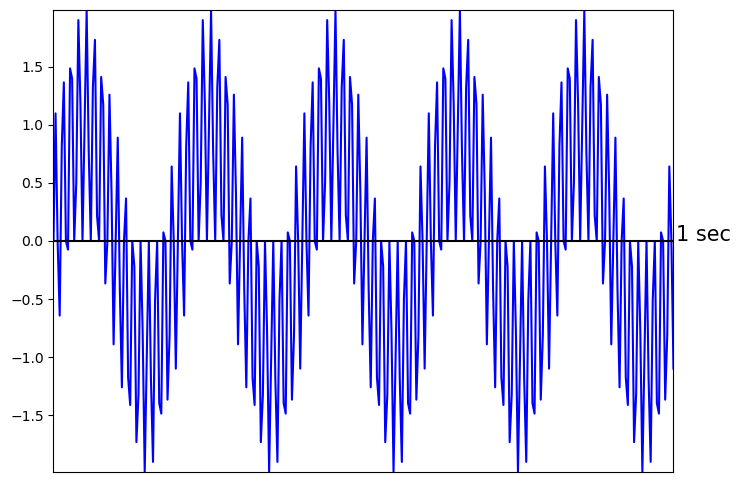

In [62]:
time = np.arange(0,1,1/300)
timeseries = np.sin(2*np.pi * 5 * time) + np.sin(2*np.pi * 80 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

A kernel of size 6 does not cover an integer number of 80 Hz cycles. What size kernel does cover an
integer number of 80 Hz cycles when sampling at 300 Hz?

Do some calculations. When sampling an 80 Hz signal at 300 Hz, a sample is available every
3.75 points (300/80). Here are some other values.

In [63]:
3.75 * 2

7.5

In [64]:
3.75 * 3

11.25

In [65]:
3.75 * 4

15.0

In [66]:
3.75 * 5

18.75

In [67]:
3.75 * 6

22.5

The above calculations show that when digitizing at 300 Hz an integer number of 80 Hz cycles occurs at
15 points (and at 2 x 15 points, 3 x 15 points, etc.). Create a kernel of 15 values and calculate the dot product between the kernel and each
datapoint in the unfiltered timeseries.

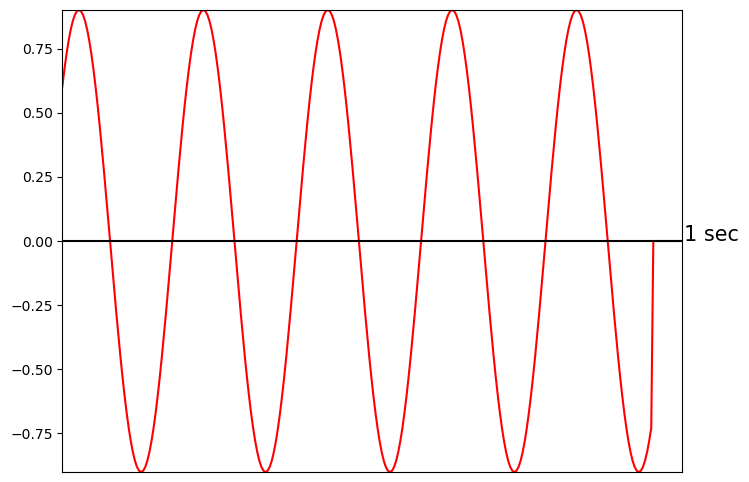

In [68]:
kernel = 1/15 * np.ones(15) #this looks like {1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15,1/15}
newydata = np.zeros(300)
for point in range(0,285):
    newydata[point] = np.dot(kernel,timeseries[point:point + 15])
newydata[285:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

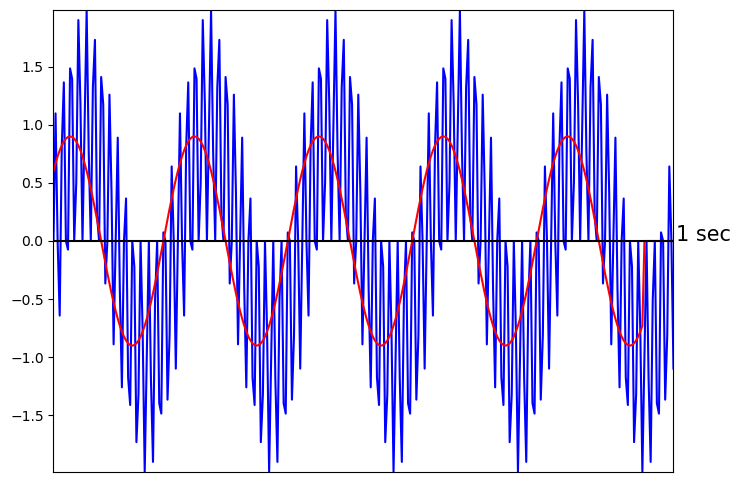

In [69]:
make_plot_2(time,timeseries,'b', time, newydata,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Is there a difference between the unfiltered timeseries (i.e., original timeseries) and the filtered
timeseries?

Answer: Take a look.

It looks like all 80 Hz activity has been removed.

Compare the power spectrum of the old and new timeseries.

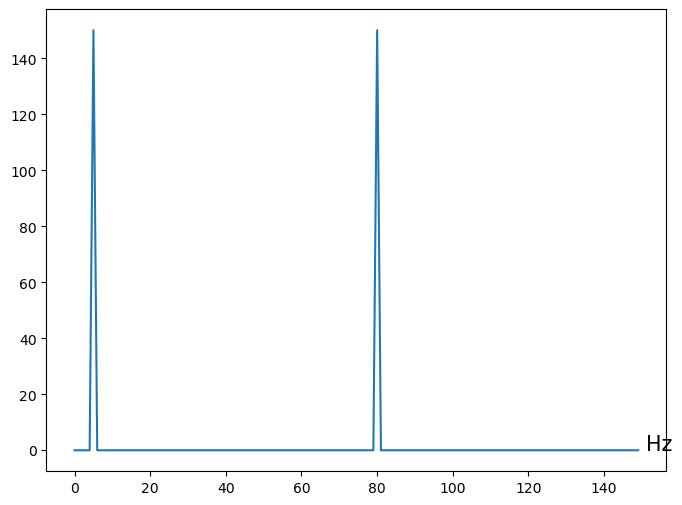

In [70]:
make_plot_freq_1(timeseries,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

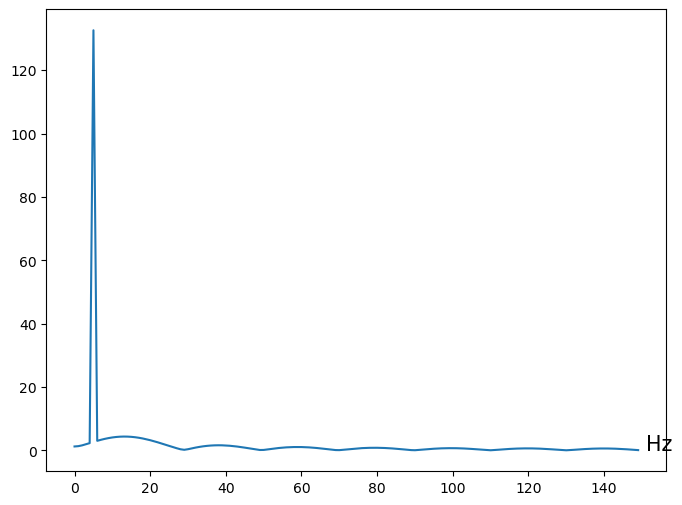

In [71]:
make_plot_freq_1(newydata,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

No 80 Hz activity! Because the kernel covered an integer number of 80 Hz cycles 80 Hz activity is averaged
out. (You'll notice that there's a bit of ripple in ther power spectrum. Don't bother about that now. More to come....)

### <font color=red>DSP.03.B3.e) Filtering success depends on the relationship between the kernel size and the sampling rate</font>

Look at this slightly more complicated example.

The timeseries below is the sum of 5 Hz, 70 Hz, and 100 Hz activity.

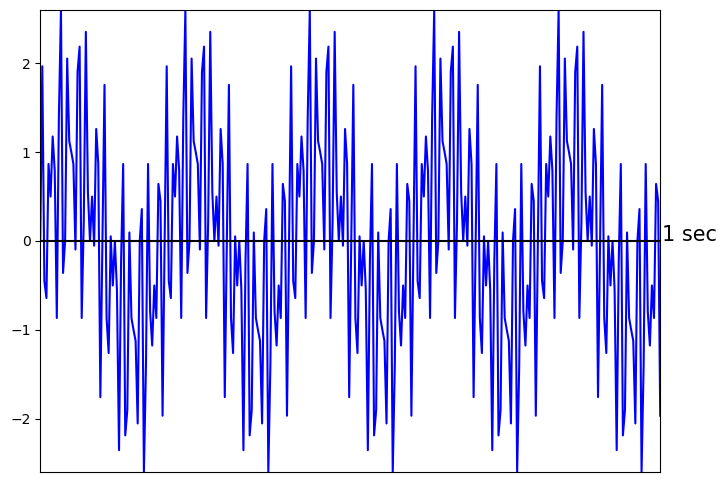

In [72]:
time = np.arange(0,1,1/300)
freq1 = 5
freq2 = 70
freq3 = 100
timeseries = np.sin(2*np.pi * freq1 * time) + np.sin(2*np.pi * freq2 * time)+ np.sin(2*np.pi * freq3 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Create a kernel that contains 6 values, and multiply each datapoint in the unfiltered data by these 6
points.

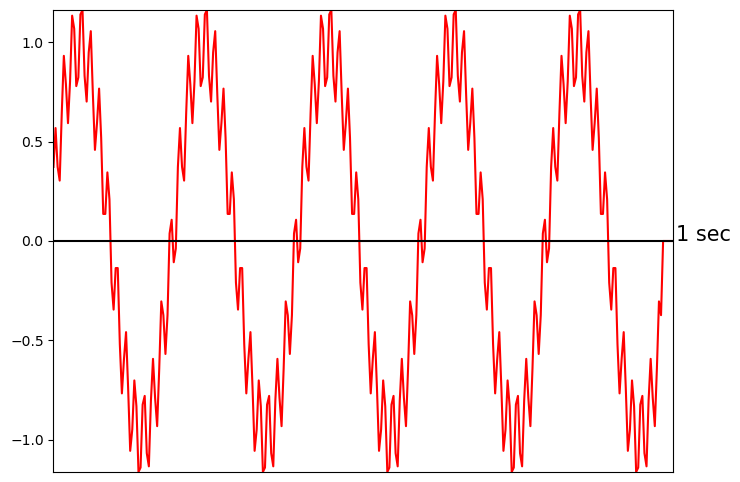

In [73]:
kernel = 1/6 * np.ones(6) #this looks like {1/6,1/6,1/6,1/6,1/6,1/6}
newydata = np.zeros(300)
for point in range(0,294):
    newydata[point] = np.dot(kernel,timeseries[point:point + 6])
newydata[294:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Is there a difference between the unfiltered timeseries (i.e., original timeseries) and the filtered
timeseries?

Answer: Take a look.

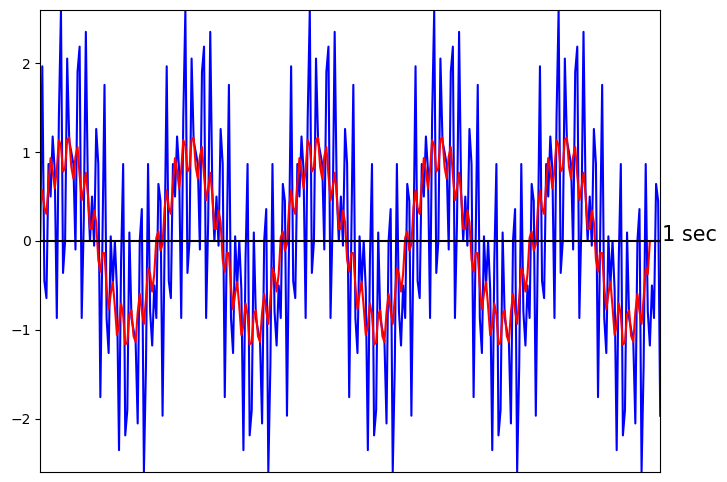

In [74]:
make_plot_2(time,timeseries,'b', time, newydata,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

They look different. Most, but not all, of the 70 Hz activity seems to have been removed.

Compare the power spectrum of the old and new timeseries.

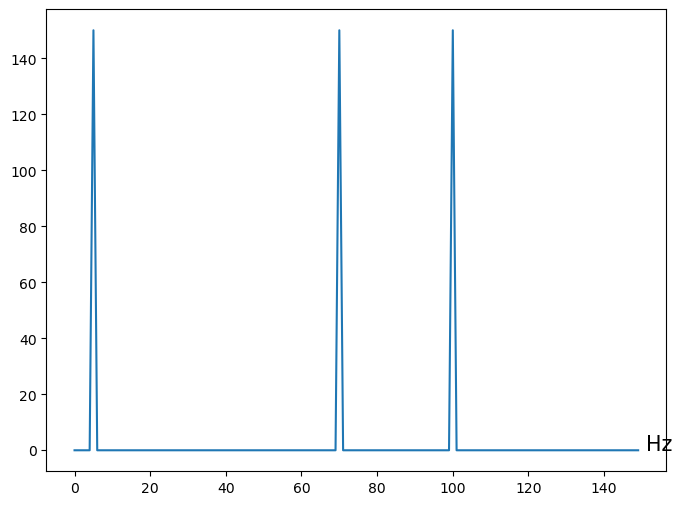

In [75]:
make_plot_freq_1(timeseries,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

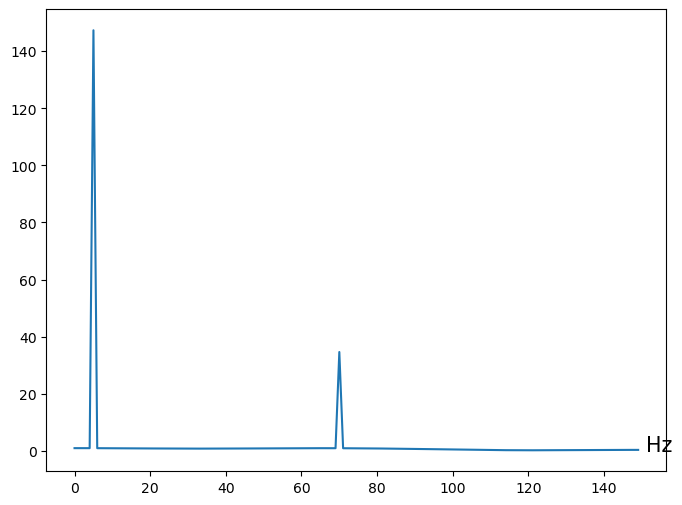

In [76]:
make_plot_freq_1(newydata,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

Although 70 Hz activity is still present, 100 Hz activity seems to have been completely removed.

The 100 Hz sine wave completes 100 full periods in 300 points. As 300/100 = 3, we need a kernel of 3 (or a
multiple of three) to cover an integer number of 100 Hz cycles, in order to filter it out.

Because the kernel of size 6 covers an integer number of 100 Hz cycles (two full cycles), almost all 100
Hz activity is removed.

The 70 Hz sine wave completes 70 full cycles in 300 points, and one full cycle in 300/70 = 4.28571 points. We
used a kernel of size 6. A kernel of size 6 does not cover an integer number of 70 Hz cycles, and thus not
all 70 Hz activity is removed.

What kernel size would do a good job of removing 70 Hz activity?

Answer:
    
The goal is to cover an integer number of 70 Hz cycles when digitizing at 300 Hz. Here are some
numbers.

In [77]:
4.28571 * 2

8.57142

In [78]:
4.28571 * 3

12.85713

In [79]:
4.28571 * 4

17.14284

In [80]:
4.28571 * 5

21.42855

In [81]:
4.28571 * 6

25.71426

In [82]:
4.28571 * 7

29.999969999999998

In [83]:
4.28571 * 8

34.28568

When digitizing at 300 Hz, within rounding error, a kernel of size 30 would cover an integer number of 70 Hz cycles.

Let's check that out.

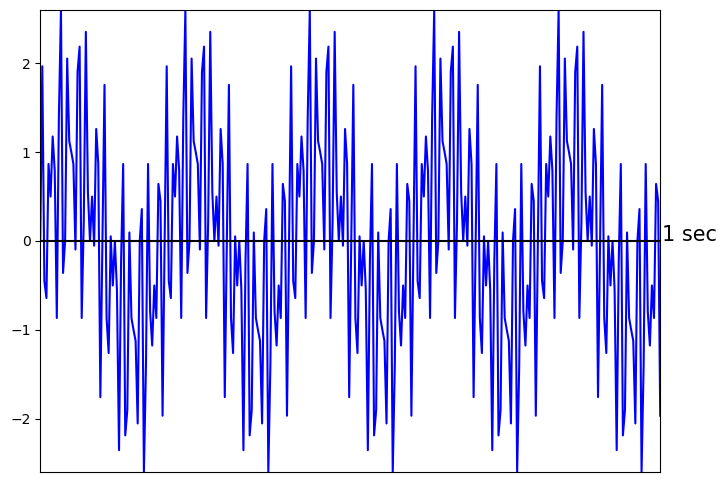

In [84]:
time = np.arange(0,1,1/300)
freq1 = 5
freq2 = 70
freq3 = 100
timeseries = np.sin(2*np.pi * freq1 * time) + np.sin(2*np.pi * freq2 * time)+ np.sin(2*np.pi * freq3 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Create a kernel of 30 values, and multiply each datapoint in the unfiltered data by these 30 points.

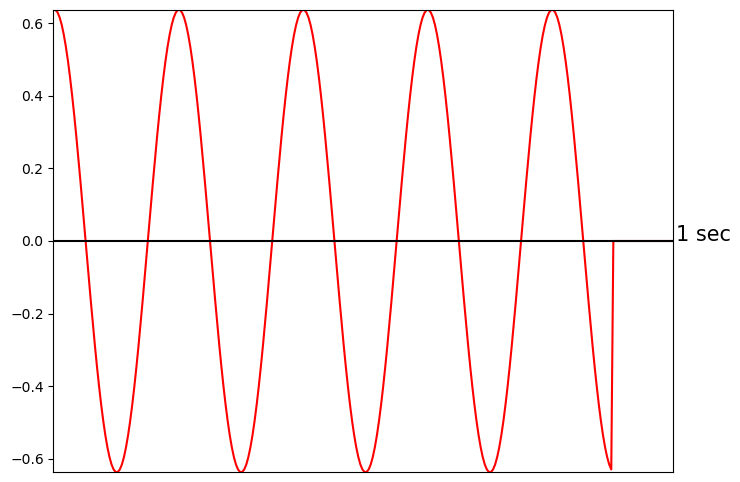

In [85]:
kernel = 1/30 * np.ones(30)
newydata = np.zeros(300)
for point in range(0,270):
    newydata[point] = np.dot(kernel,timeseries[point:point + 30])
newydata[270:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Compared the unfiltered and the filtered timeseries.

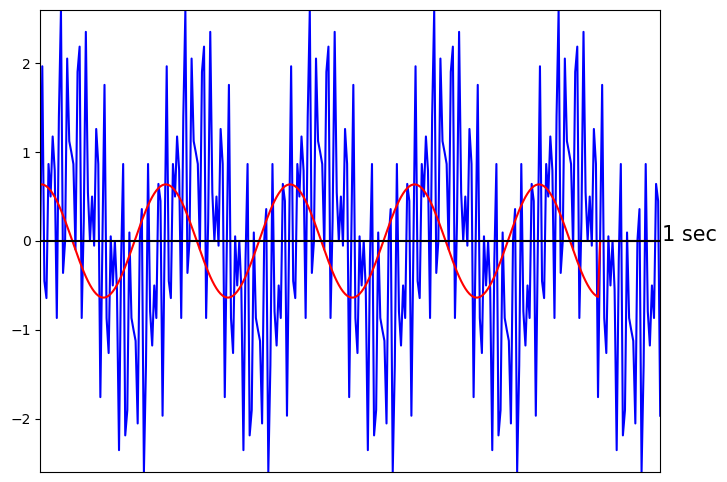

In [86]:
make_plot_2(time,timeseries,'b', time, newydata,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

You might have noticed in that plot that the red line in this latest plot is shifted to the left relative to the blue line. It
happened because we plotted the start of the red and blue lines both at the first point in the timeseries,
but in fact, with an 30-weight filter, we can’t filter the first 15 points. So to be more precise we should
shift the blue line to start 15 points later than the red line.

Here is one way to do that.

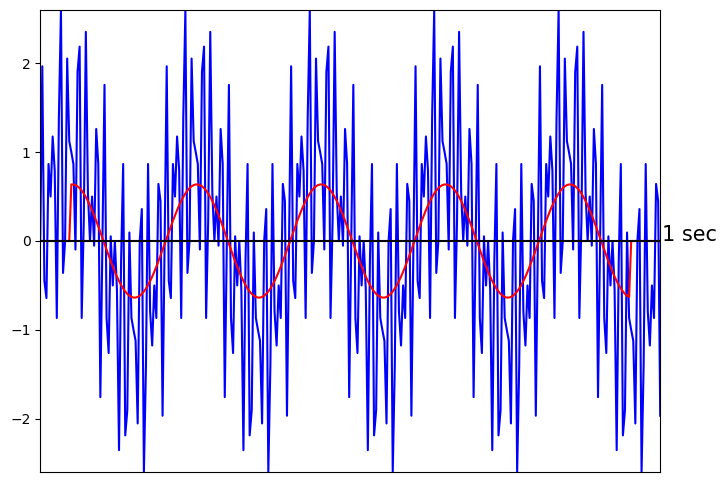

In [87]:
newydata2 = np.zeros(300)
newydata2[15:285] = newydata[:270]

make_plot_2(time,timeseries,'b', time, newydata2,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Ignoring the start and end, now the black line tracks the 5 Hz activity in the red line quite well. 

Compare the power spectrum of the old and new timeseries.

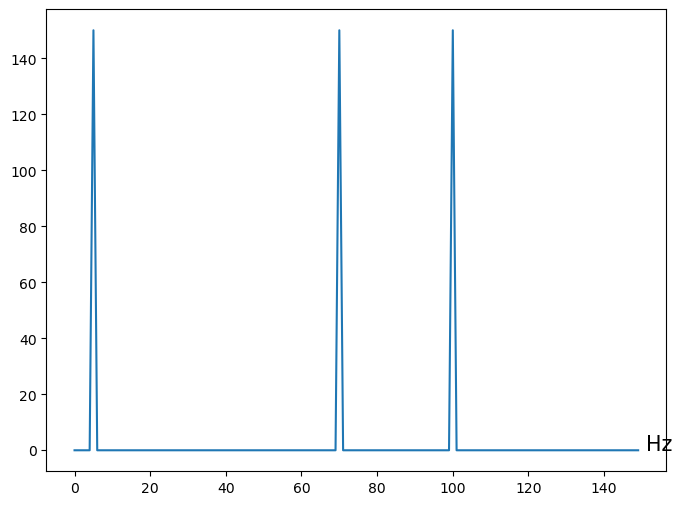

In [88]:
make_plot_freq_1(timeseries,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

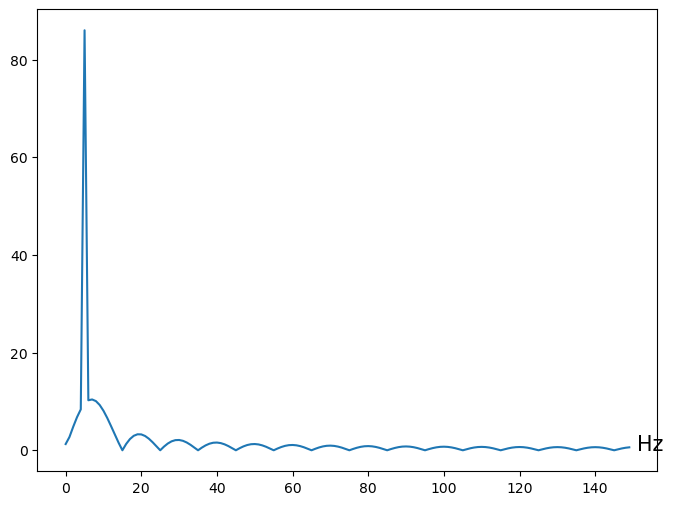

In [89]:
make_plot_freq_1(newydata2,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

Looks like 70 Hz activity and 100 Hz activity were removed. (Again, for now, ignore the ripple. It's important, but not yet.) We had good reason to suspect 70 Hz activity would
be removed. Why was 100 Hz activity also removed?

Answer:
    
A kernel of size 30 was applied. As 300/100 = 3, we need a kernel of 3 (or a multiple of three) to cover an
integer number of 100 Hz cycles. A kernel of size 30 covers an integer number of 100 Hz cycles and thus
removed 100 Hz activity.

So, given a sampling rate of 300 Hz, a kernel size of 30 was a good choice for filtering out both 70 Hz activity and 100 Hz activity. You can imagine that designing effective digital filters can depend on having a good idea of what signals are in the timeseries you want to filter.

### <font color=red>DSP.03.B3.f) High-pass filters, low-pass filters, and filter gain</font>

Look at this timeseries, with 4 constituent frequencies sampled (digitized) at 300 Hz.

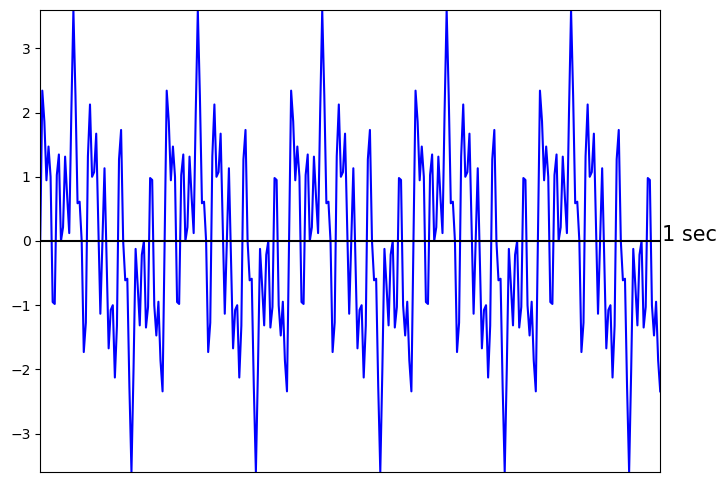

In [90]:
time = np.arange(0,1,1/300)
freq1 = 5
freq2 = 25
freq3 = 40
freq4 = 80
timeseries = np.sin(2*np.pi * freq1 * time) + np.sin(2*np.pi * freq2 * time)+ \
            np.sin(2*np.pi * freq3 * time) + np.sin(2*np.pi * freq4 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

To filter the data, create a kernel of 6 equally weighted values and multiply each datapoint in the
unfiltered data by this kernel. (So far, all the weights have been the same in any of the kernels we've created. They don't have to be same, which will open up rich possibilities for us. But for now we're sticking with equal-weight filters, each weight being the reciprocal of the length of the filter.)

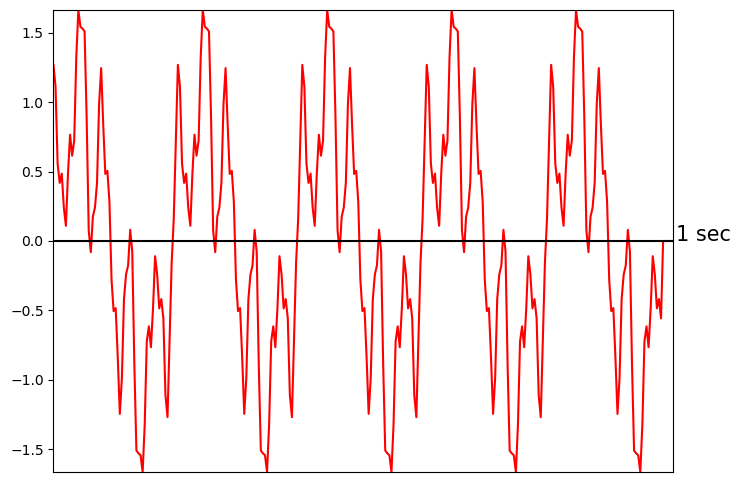

In [91]:
kernel = 1/6 * np.ones(6)
newydata = np.zeros(300)
for point in range(0,294):
    newydata[point] = np.dot(kernel,timeseries[point:point + 6])
newydata[294:300] = 0

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Is there a difference between the original unfiltered timeseries and the filtered timeseries (created by
calculating the dot product between the kernel and each datapoint in the original timeseries)?

Answer: Take a look.

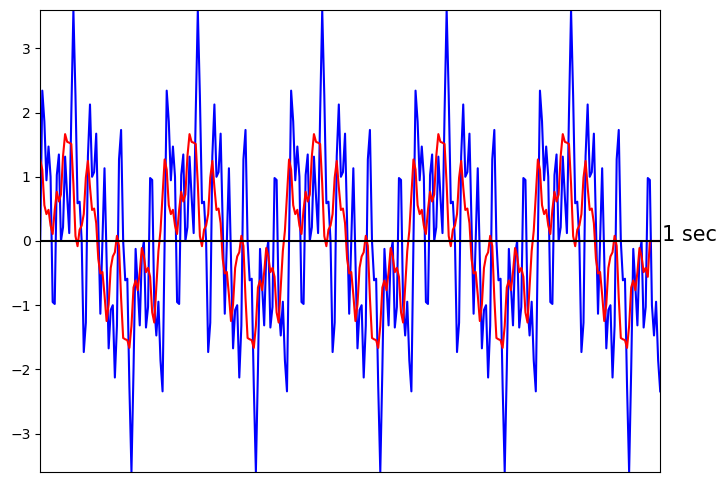

In [92]:
make_plot_2(time,timeseries,'b', time, newydata,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

They look different. Low-frequency information seems to have been retained and some high-frequency
activity removed.

Let’s again correct the plot so that the unfiltered and filtered timeseries line up more accurately. With
an 6-weight filter, we can’t filter the first 3 points. So to be more precise we should shift the black line to
start 4 points later than the red line. 

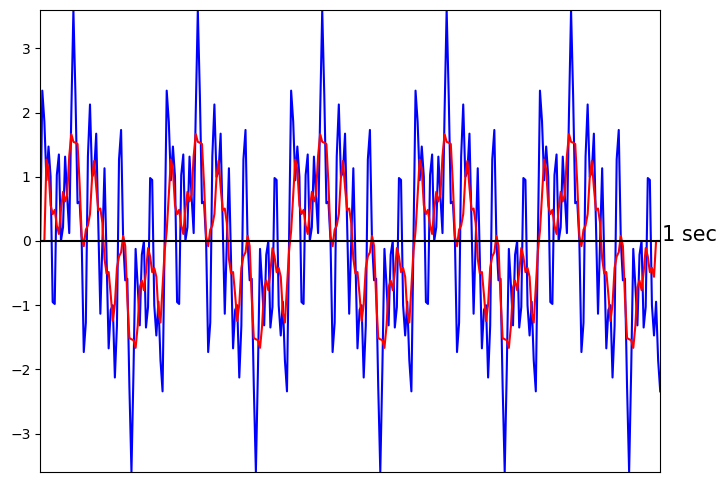

In [93]:
newydata2 = np.zeros(300)
newydata2[3:298] = newydata[:295]

make_plot_2(time,timeseries,'b', time, newydata2,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

In the remaining examples, we’ll use the above proceedure to align the unfiltered and filtered timeseries.

Compare the power spectrum of the old and new timeseries.

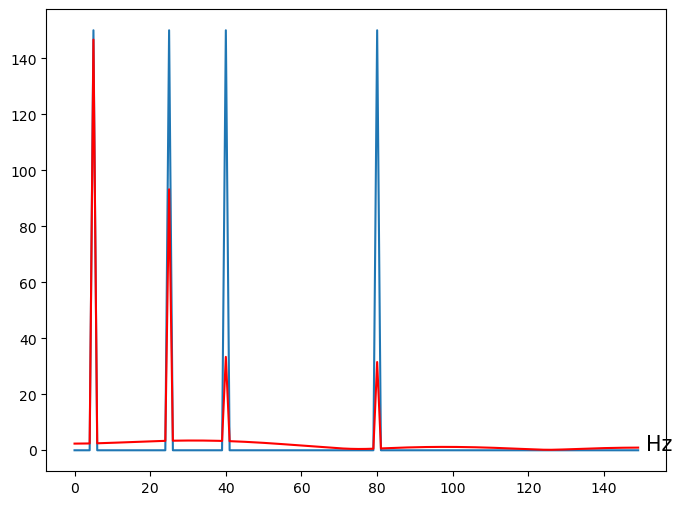

In [94]:
make_plot_freq_2(timeseries,newydata2,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

80 Hz, 40 Hz, and 20 Hz signals have been attenuated (shown in red). The greatest attenuation was for 80
Hz activity, then 40 Hz, and then 20 Hz. Almost all of the 5 Hz signal survived.

We can think of what we did as one way to apply a digital filter. The most commonly considered filters are high-pass and low-pass, which selectively attenuate low-frequency and high-frequency
components, respectively. That's true of electronic analog filters (applied before we digitize) and mathematical digital filters (applied after we digitize).

In the examples above, high-frequency activity was attenuated. Thus, we say that a low-pass filter was
applied, selectively attenuating high-frequency activity. A high-pass filter would do the opposite -
selectively attenuating low-frequency activity.

### <font color=red>DSP.03.B3.g) Implementing Digital Filters</font>

Look at another timeseries.

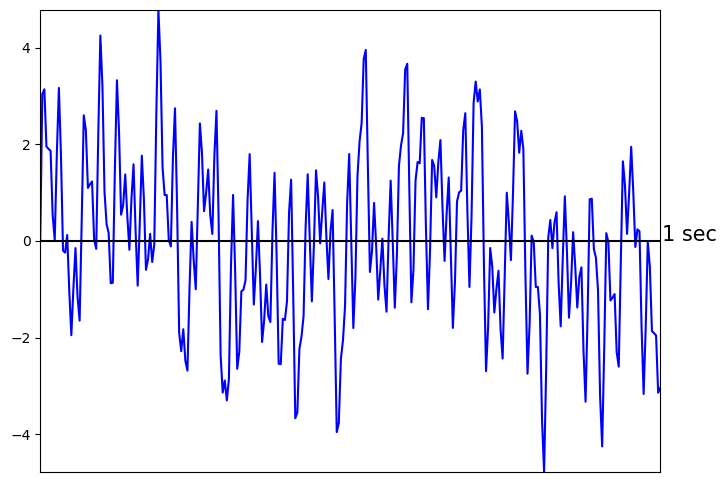

In [95]:
time = np.arange(0,1,1/300)
freq1 = 2
freq2 = 12
freq3 = 16
freq4 = 33
freq5 = 43
freq6 = 75
timeseries = np.sin(2*np.pi * freq1 * time) + np.sin(2*np.pi * freq2 * time)+ np.sin(2*np.pi * freq3 * time) \
            + np.sin(2*np.pi * freq4 * time)+ np.sin(2*np.pi * freq5 * time)+ np.sin(2*np.pi * freq6 * time)

make_plot_1(time,timeseries,'b')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

To filter the data, create a kernel of 10 equally weighted values and multiply each datapoint in the
unfiltered data by this kernel.

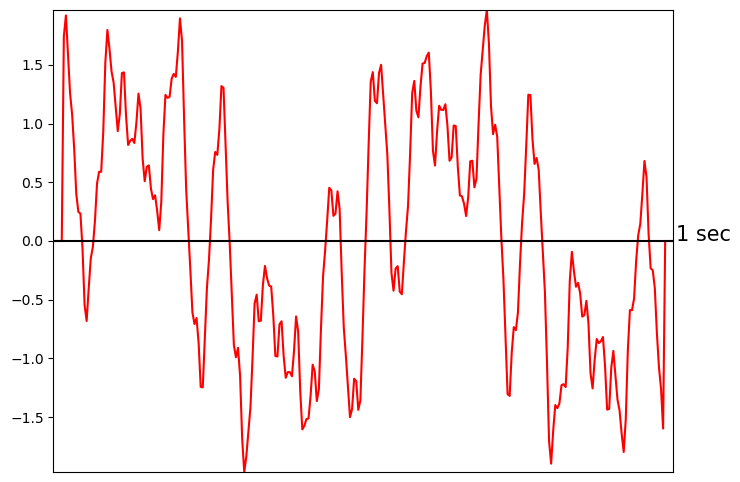

In [96]:
kernel = 1/10 * np.ones(10)
newydata = np.zeros(300)
for point in range(0,290):
    newydata[point] = np.dot(kernel,timeseries[point:point + 10])
newydata2 = np.zeros(300)
newydata2[5:295] = newydata[:290]

make_plot_1(time,newydata2, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Take a look at the difference between the original timeseries and the filtered timeseries. 

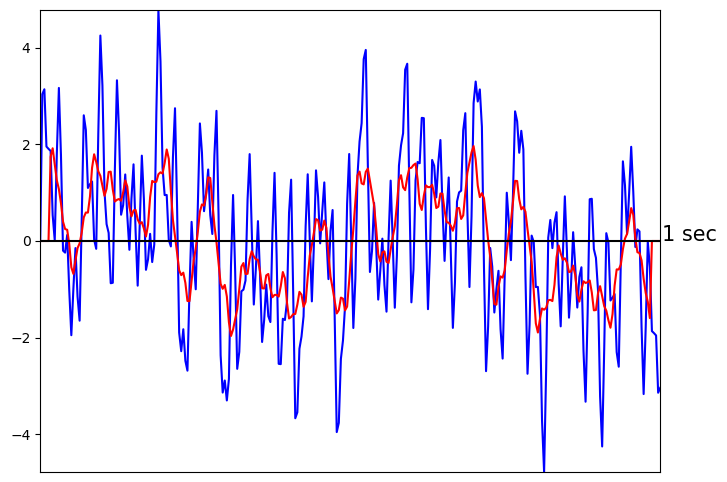

In [97]:
make_plot_2(time,timeseries,'b', time, newydata2,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Low-frequency information seems to have been retained and some high-frequency activity removed.

Compare the power spectrum of the old and new timeseries.

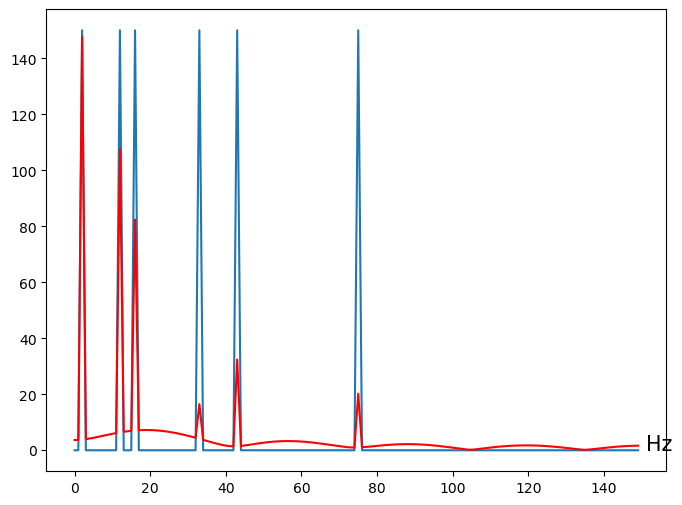

In [98]:
make_plot_freq_2(timeseries,newydata2,300)

# Adding text to the figure
plt.text(151,0,'Hz',fontsize=15)
plt.show()

The filtered power spectrum is shown in red.

What type of filter was applied?

Answer:
    
The kernel applied to the original timeseries attenuated high-frequency activity. Thus, we applied a
low-pass filter.

Using the terms "low-pass" and "high-pass" correctly can be confusing. Try this trick. When you apply a filter to remove high-frequency
activity, you are saying that you 'passed' frequencies below a certain frequency. Thus, you applied a low-pass filter, passing frequencies lower
than the cutoff frequency. Alternatively, when applying a filter to remove low-frequency activity, you are saying that you 'passed' frequencies
above some frequency. Therefore, you applied a high-pass filter, passing frequencies higher than a particular frequency.

Think of this on a
music sound system that has separate bass and treble controls. The bass control works like a high-pass filter (reducing low frequencies if you turn it down), and the treble control works like a low-pass
filter (reducing high frequencies if you turn it down). If you "turn up the treble", what is probably going on inside the box is that you're raising the low-pass filter's cutoff frequency, fc.

Sometimes you run across the terms "high" and "low" to refer to filters. Those are ambiguous: "high" can refer to what the filter is passing or what it's removing. Better to use the longer terms "high-pass" and "low-pass", to avoid ambiguity.

## <font color=red>DSP.03.B4) Convolving and Filters - Part II</font>

### <font color=red>DSP.03.B4.a) Convolving (just a big word for multiplying and adding)</font>

In a common type of digital filter, each filtered output point is defined as a weighted or unweighted
average of some number of input data points. A filter is called “unweighted” when all the weights are
the same, such as 1/5, and “weighted” when the weights differ, which we’ll get to later. This sounds a
little odd, because all types of filters use weights, so are “weighted”. Implicitly, “weighted” means “weighted
differently", and "unweighted" means "weighted equally".

Let vector K (the kernel) consist of 2j+1 weights (subscripted -j to +j) that will be used to compute
output vector Filteredt (filtered timeseries) from input vector Unfilteredt (unfiltered timeseries). Typically,
Filteredt and Unfilteredt are the same length (Filteredt may be a bit shorter, as some filters are
not applicable near the ends of the time series), and the kernel K is much shorter than Filteredt and Unfilteredt.

As shown in the
examples above, the sample period (distance in time between the points in Unfilteredt), the number of
weights, and the values of those weights affect the behavior of the filter. 2j+1 input data points (a
portion of vector Unfilteredt) will be included in the computation of each filtered output point (to be
stored in vector Filteredt).

Here we'll introduce a new verb, but it does something we already know:
Each value in Filteredt is computed by "convolving" the 2j+1 weights in the kernel K with 2j+1 values in
Unfilteredt. Convolution is the sum of the cross-products of (a) the kernel weights and (b) the corresponding
Unfilteredt values (i.e., the dot product):
    
Filteredt = $\sum\limits_{i=-j}^{j}$ Ki Unfilteredt + i                                    

That was a lot of text. One take-home point is that, to calculate Filteredt, we simply take the dot product of
the (short) kernel and the unfiltered timeseries as we slide the kernel along the unfiltered timeseries. Take a look.

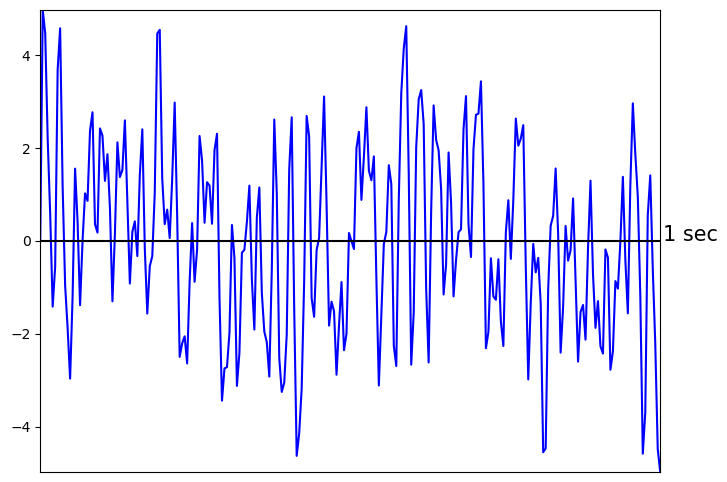

In [99]:
time = np.arange(0,1,1/250)
freq1 = 2
freq2 = 12
freq3 = 16
freq4 = 33
freq5 = 38
freq6 = 40
freq7 = 43
freq8 = 75

timeseries = np.sin(2*np.pi * freq1 * time) + np.sin(2*np.pi * freq2 * time)+ np.sin(2*np.pi * freq3 * time) \
            + np.sin(2*np.pi * freq4 * time)+ np.sin(2*np.pi * freq5 * time)+ np.sin(2*np.pi * freq6 * time)\
            + np.sin(2*np.pi * freq7 * time)+ np.sin(2*np.pi * freq8 * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

In the previous sections we used the Python 'Dot' function and a 'For' loop to calculate the dot
product between the kernel and the original timeseries at each point. This process is called convolution.
But we can make this a bit easier - enough of the hard work! Let's can make our lives easier - the Python Scipy.signal
'convolve' function accomplishes all the above procedures with a single line of code. 

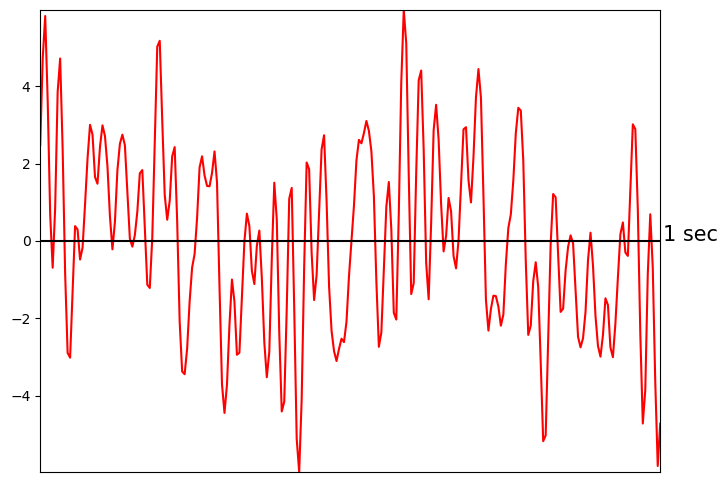

In [100]:
from scipy import signal

kernel = 1/2 * np.ones(3)
newydata = signal.convolve(timeseries,kernel,mode='same')

make_plot_1(time,newydata, 'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

In forming subsets of input data points to combine with a kernel, there is always an issue of what to do at the ends of the original timeseries. To get output that is as long as the original vector of data, in Python the syntax "mode='same'" is used, with the output data the same size as the input data.   
         
Look at the unfiltered and filtered timeseries.

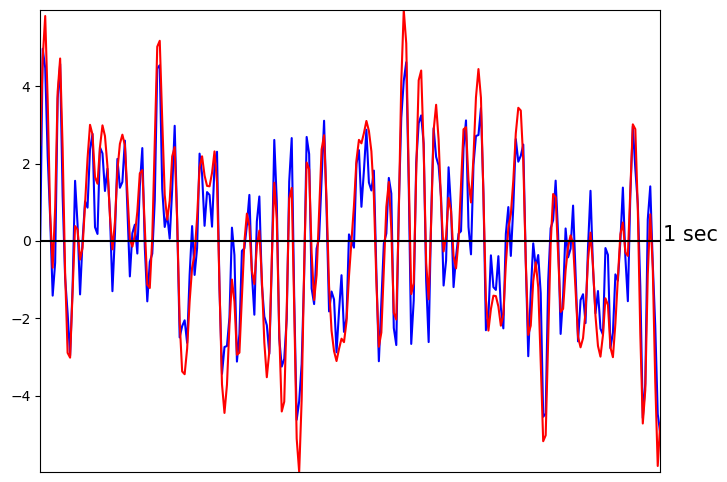

In [101]:
make_plot_2(time,timeseries,'b', time, newydata,'r')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Not much of a difference. Most low- and high-frequency information has been retained

Compare their powerspectrum.

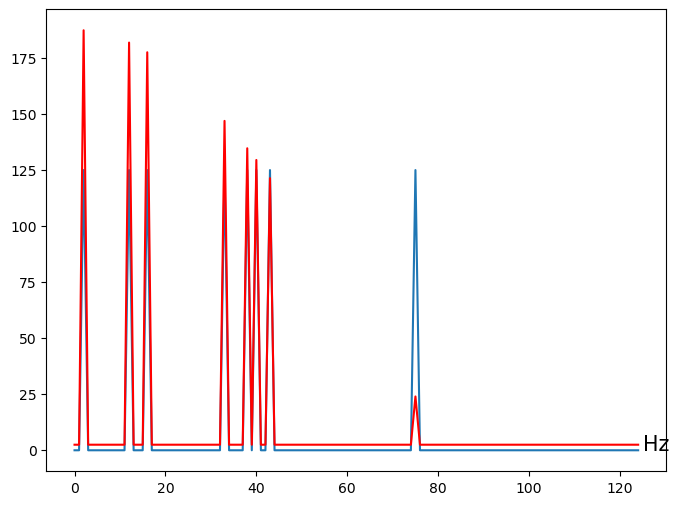

In [102]:
make_plot_freq_2(timeseries,newydata,250)

# Adding text to the figure
plt.text(125,0,'Hz',fontsize=15)
plt.show()

High-frequency activity is only very minimally attenuated with this particular low-pass filter.
Why wasn't much activity removed?

Answer:
    
Here are the frequencies composing the above timeseries: 2 Hz, 12 Hz, 16 Hz, 33 Hz, 38 Hz, 40 Hz, 43 Hz,
and 75 Hz.

We sampled at 250 Hz. Divide 250 by each frequency to determine how many points are in 1 full period of each frequency.

In [103]:
250/2

125.0

In [104]:
250/12

20.833333333333332

In [105]:
250/16

15.625

In [106]:
250/33

7.575757575757576

In [107]:
250/38

6.578947368421052

In [108]:
250/40

6.25

In [109]:
250/43

5.813953488372093

In [110]:
250/75

3.3333333333333335

The above is the number of points needed to cover one full cycle of each frequency. A kernel of size 3
does not completely cover a full cycle of any of the frequencies that compose the timeseries. As a
result, little activity at any of these frequencies is removed.

### <font color=red>DSP.03.B4.b) Convolving (just a big word for multiplying and adding)</font>

Let's review some of the text at the beginning of the Section B4.a text again. 

Let vector K (the kernel) consist of 2j+1 weights (subscripted -j to +j) that will be used to compute
output vector Filteredt (filtered timeseries) from input vector Unfilteredt (unfiltered timeseries). Typically,
Filteredt and Unfilteredt are the same length (Filteredt may be a bit shorter, as some filters are not applicable near the ends of the time series), and the kernel K is much shorter.

As shown above, the
sample period (distance in time between the points in Unfilteredt), the number of weights, and the
values of those weights affect the gain function of the filter. 2j+1 input data points (a portion of vector
Unfilteredt) will be included in the computation of each filtered output point (to be stored in vector
Filteredt). Each value in Filteredt is computed by convolving the 2j+1 weights in the kernel K with 2j+1
values in Unfilteredt. Convolution is the sum of the cross-products of the kernel weights and corresponding
Unfilteredt values (i.e., the dot product):
    
Filteredt = $\sum\limits_{i=-j}^{j}$ Ki Unfilteredt + i   
    
Let's consider a way to improve the performance of our filters.

Once again, the kernel consists of 2j+1 weights, but let's loosen things up a bit.

Notice that nothing in the text above says the kernel weights have to be the same.

Notice that nothing in the text above says the kernel weights have to be the reciprocal of the length of
the timeseries.

The kernels examined thus far are kernels used to create what is commonly called a moving-average
filter, because they compute a simple average, due to all the weights in the kernel being the same = 1 ÷ # weights. Another common name for that filter is "boxcar", because if you plot the weights they'd form a rectangle.

Other kernels are possible! The weights don't have to all be the same, and there are many ways to
generate the weights that make up the kernel. If you're interested in this topic, you might take a more
advanced digital signal processing class on filter design. (Two accessible introductions are: (a) Cook, E.W., III, & Miller, G.A. (1992). Digital filtering: Background and tutorial for psychophysiologists. Psychophysiology, 29, 350-367. (b)
Edgar, J.C., Stewart, J.L., & Miller, G.A. (2005). Digital filtering in EEG/ERP research. In T.C. Handy (Ed.), Event-related potentials: A handbook (pp. 85-113). Cambridge, MA: MIT Press. 

### <font color=red>DSP.03.B4.c) Some extra information</font>

Here again is the filtering formula applied above.

Filteredt = $\sum\limits_{i=-j}^{j}$ Ki Unfilteredt + i                 

If you are 'in the know', then you will know that this type of filter is called a nonrecursive filter or a
Finite Impulse Response filter (FIR filter). A filter is a FIR filter when only the original data values are
used to compute the output values contained in Filteredt. (One could use filtered values for some of the points to which one applies weights in computer the filtered value for another point. FIR filters don't do that.)

Nonrecurive or finite impulse response filters (FIR filters) occur in many different fields.
In each field, this type of filter is sometimes given a different name. Here are some of the more common names you might encounter:

Nonrecursive filter

Finite impulse response filter

FIR filter

Transversal filter

Tapped delay line filter

Moving average filter